## 5. Data Amalgamation, Exploratory Data Analysis, Data Transformation and Basic Modelling
__Project - BSTN Capstone__
<br>__Beth McGregor__

#### Introduction
This notebook follows __4. Data Cleanup and Preparation__. First, data from the Chicago, Berlin and London Marathons are combined into a single csv file that will be used for exploratory data analysis and basic modelling. Next, the distributions of features are explored and some basic analysis is done to look at differences in finish times between and within the races. Finally, some basic modelling is attempted using the combined dataset.   

In [113]:
# Load the required libraries for this notebook

import numpy as np
import pandas as pd
import re

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
from scipy import stats
import statsmodels.api as sm
## Tukey's HSD
from statsmodels.stats import multicomp

# Data Transformation
from sklearn.preprocessing import OneHotEncoder

# Modelling
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import joblib

In [119]:
# Combine the race results for location into one csv file (source of code is above)

import os
import glob

extension = 'csv'
all_filenames = ['Data/berlin/output/berlin_results_reduced.csv',
                 'Data/london/output/london_results_reduced_df.csv',
                 'Data/chicago/output/chicago_results_reduced_df.csv']

# combine all files in the list
combined_cleaned_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

# export to csv
combined_cleaned_csv.to_csv("Data/cleaned data/reduced_features/combined_cleaned.csv", index=False, encoding='utf-8-sig')


NOTE: Only run the above file once. If it is run multiple times, it will create multiple files and results in duplicated data. 

In [120]:
# Read in the combined csv with results from all marathons
marathon_df = pd.read_csv('Data/cleaned data/reduced_features/combined_cleaned.csv')
marathon_df.head()

,Unnamed: 0,marathon_name,year,place_overall,full_name,elite_status,nationality,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,course_turns,temperature_min,temperature_max,precipitation
0,0,berlin,2015,1,Eliud Kipchoge,1,KEN,M,7440,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0
1,1,berlin,2015,2,Eliud Kiptanui,1,KEN,M,7521,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0
2,2,berlin,2015,3,Feyisa Lilesa,1,ETH,M,7617,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0
3,3,berlin,2015,4,Emmanuel Mutai,1,KEN,M,7666,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0
4,4,berlin,2015,5,Geoffrey Mutai,1,KEN,M,7769,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0


In [121]:
# drop the "Unnamed: 0" column that is a result of concatenating the multiple tables
marathon_df.drop('Unnamed: 0', inplace = True, axis = 1)

In [122]:
# Get the shape of the dataframe
marathon_df.shape

(710813, 18)

The combined marathon_df contains 710,813 rows and 18 columns. 

In [123]:
# Look at the top 5 rows of data
marathon_df.head()

,marathon_name,year,place_overall,full_name,elite_status,nationality,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,course_turns,temperature_min,temperature_max,precipitation
0,berlin,2015,1,Eliud Kipchoge,1,KEN,M,7440,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0
1,berlin,2015,2,Eliud Kiptanui,1,KEN,M,7521,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0
2,berlin,2015,3,Feyisa Lilesa,1,ETH,M,7617,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0
3,berlin,2015,4,Emmanuel Mutai,1,KEN,M,7666,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0
4,berlin,2015,5,Geoffrey Mutai,1,KEN,M,7769,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0


In [124]:
# Look at the data types
marathon_df.dtypes

marathon_name           object
year                     int64
place_overall            int64
full_name               object
elite_status             int64
nationality             object
gender                  object
finish_time_seconds      int64
altitude_start         float64
altitude_finish        float64
max_slope              float64
min_slope              float64
elevation_gain         float64
elevation_loss         float64
course_turns             int64
temperature_min        float64
temperature_max        float64
precipitation          float64
dtype: object

The data types all appear to be appropriate for the variables. Some will be later converted to binary, or encoded: 
- marathon_name
- nationality
- gender


In [125]:
# Quality Control - Check that there are no missing values
marathon_df.isna().sum()

marathon_name          0
year                   0
place_overall          0
full_name              0
elite_status           0
nationality            0
gender                 0
finish_time_seconds    0
altitude_start         0
altitude_finish        0
max_slope              0
min_slope              0
elevation_gain         0
elevation_loss         0
course_turns           0
temperature_min        0
temperature_max        0
precipitation          0
dtype: int64

In [126]:
# Quality Control - Check that there are no duplicated rows
marathon_df.duplicated().sum()

34

Unfortunately 34 duplicated rows were identified. This is unexpected as no duplicate rows were identified in each of the individual marathons. This needs to be explored further. 

In [127]:
# Print out the rows identified as duplicates
marathon_df[marathon_df[['year', 'place_overall','full_name']].duplicated()]

,marathon_name,year,place_overall,full_name,elite_status,nationality,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,course_turns,temperature_min,temperature_max,precipitation
11601,berlin,2015,11608,Willy Hamma,0,GER,M,13429,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0
34336,berlin,2015,34351,Carlita Metzdorf-Klos,0,GER,W,19211,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0
35858,berlin,2015,35873,Jean-Pierre Valera,0,FRA,M,20799,33.99,33.99,1.6,-1.7,77.11,-77.11,45,6.5,17.4,0.0
39731,berlin,2014,2977,Christoph Bader,0,DEU,M,11776,33.99,33.99,1.6,-1.7,77.11,-77.11,45,5.8,21.5,0.0
43150,berlin,2014,6395,Lisa Clemens,0,DEU,W,12818,33.99,33.99,1.6,-1.7,77.11,-77.11,45,5.8,21.5,0.0
46503,berlin,2014,9749,Annett Roth,0,DEU,W,13606,33.99,33.99,1.6,-1.7,77.11,-77.11,45,5.8,21.5,0.0
50464,berlin,2014,13708,Carsten Roth,0,DEU,M,14354,33.99,33.99,1.6,-1.7,77.11,-77.11,45,5.8,21.5,0.0
51737,berlin,2014,14984,Jan Delitz,0,DEU,M,14651,33.99,33.99,1.6,-1.7,77.11,-77.11,45,5.8,21.5,0.0
56424,berlin,2014,19675,Thomas Schmittberger,0,DEU,M,15877,33.99,33.99,1.6,-1.7,77.11,-77.11,45,5.8,21.5,0.0
56425,berlin,2014,19675,Thomas Schmittberger,0,DEU,M,15877,33.99,33.99,1.6,-1.7,77.11,-77.11,45,5.8,21.5,0.0


In [11]:
# Investigate duplicate rows for runner Michael Wardian
marathon_df[marathon_df['full_name']== 'Michael Wardian']

,marathon_name,year,place_overall,full_name,elite_status,nationality,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,course_turns,temperature_min,temperature_max,precipitation
155830,london,2016,43,Michael Wardian,0,USA,M,8857,39.75,6.95,5.5,-10.3,137.40,-170.20,56,3.1,12.1,0.00
297728,berlin,2016,71,Michael Wardian,0,USA,M,8899,33.99,33.99,1.6,-1.7,77.11,-77.11,45,8.8,22.8,0.00
504962,chicago,2018,1826,Michael Wardian,0,USA,M,11147,182.94,182.82,3.8,-5.9,57.91,-58.03,42,13.9,18.3,20.83
547926,chicago,2016,71,Michael Wardian,0,USA,M,9122,182.94,182.82,3.8,-5.9,57.91,-58.03,42,10.0,17.2,0.00


It turns out that a Michael Wardian ran both the Berlin and Chicago marathons in 2016, finishing 71st in both marathons. If this is indeed the same person, this is an impressive accomplishment given that these marathons are only a few weeks apart! 

In [12]:
# Investigate duplicate rows for runner Thomas Schmittberger
marathon_df[marathon_df['full_name']== 'Thomas Schmittberger']

,marathon_name,year,place_overall,full_name,elite_status,nationality,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,course_turns,temperature_min,temperature_max,precipitation
288384,berlin,2014,19675,Thomas Schmittberger,0,DEU,M,15877,33.99,33.99,1.6,-1.7,77.11,-77.11,45,5.8,21.5,0.0
288386,berlin,2014,19675,Thomas Schmittberger,0,DEU,M,15877,33.99,33.99,1.6,-1.7,77.11,-77.11,45,5.8,21.5,0.0
288387,berlin,2014,19675,Thomas Schmittberger,0,DEU,M,15877,33.99,33.99,1.6,-1.7,77.11,-77.11,45,5.8,21.5,0.0


After going back to look at the 2014 results of the Berlin Marathon, it turns out that there were 3 different sequential bib numbers assigned to individuals with the name 'Thomas Schmittberger' (25695, 25696, 25697). There were also other runners with the surname 'Schmittberger' that finished just before and after these runners. I will make the assumption that these runners were distinct individuals running as part of a family group. 

As I have removed the bib numbers for this combined dataset, it is difficult to definitively confirm that the remainder of the rows identified above are duplicated. As no duplicated rows were identified in each of the the individual marathons, I am going to make the assumption thath these rows are not duplicates and keep them. 

#### Start to Explore the Numeric Columns: 

In [13]:
marathon_numeric_columns_df = marathon_df[['year', 'place_overall', 'finish_time_seconds', 'elite_status', 'altitude_start', 'altitude_finish', 'max_slope', 'min_slope', 'elevation_gain', 'elevation_loss', 'course_turns', 'temperature_min', 'temperature_max', 'precipitation' ]]


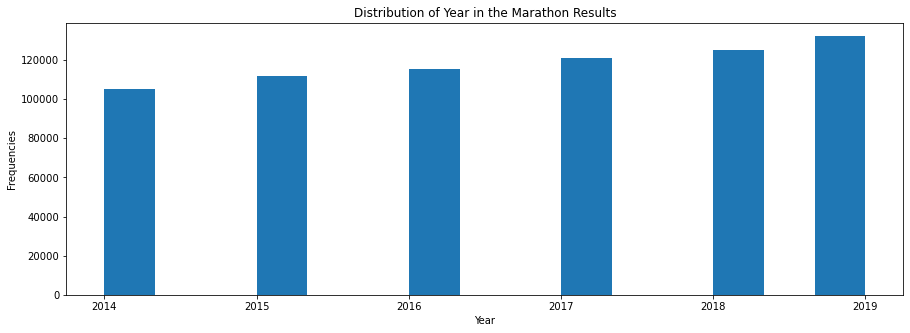

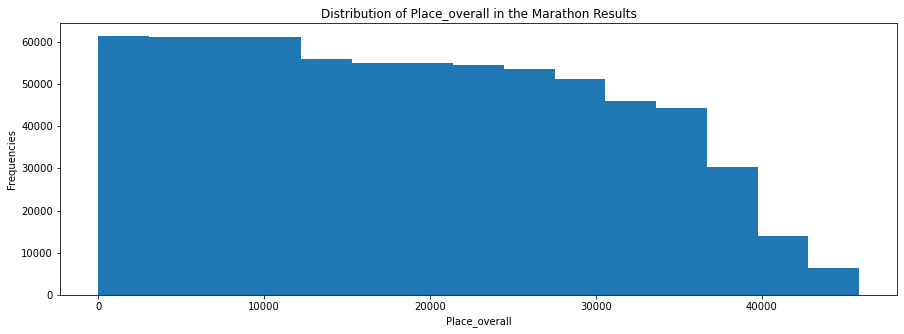

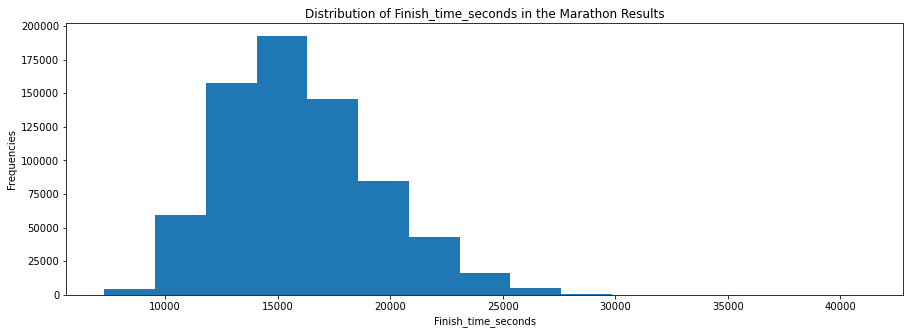

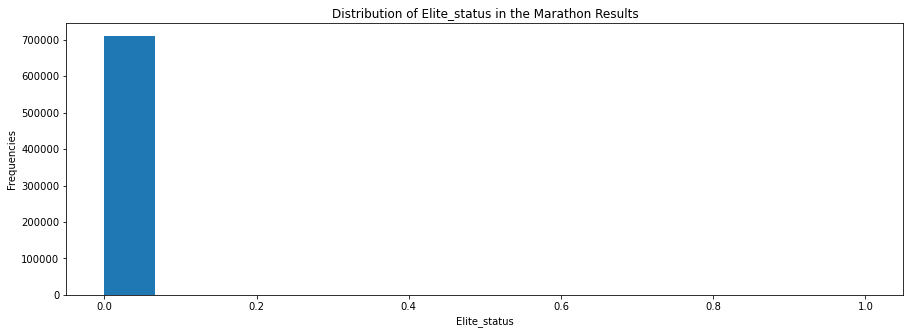

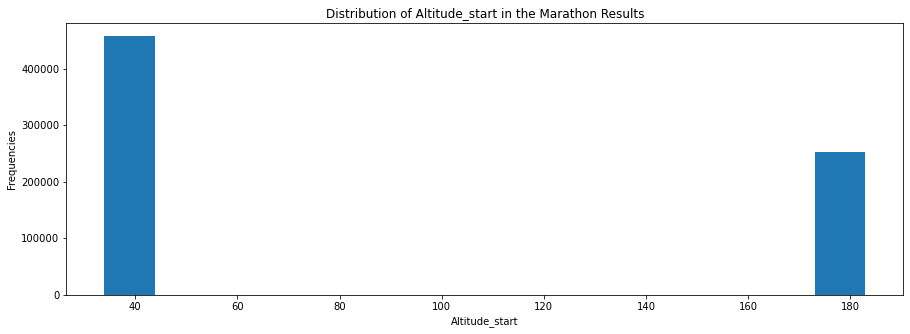

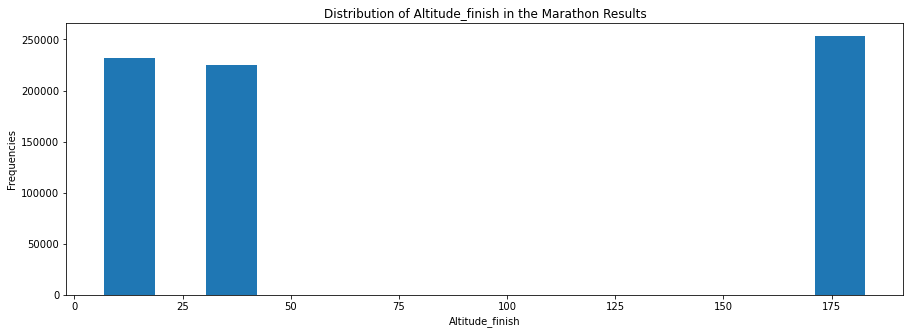

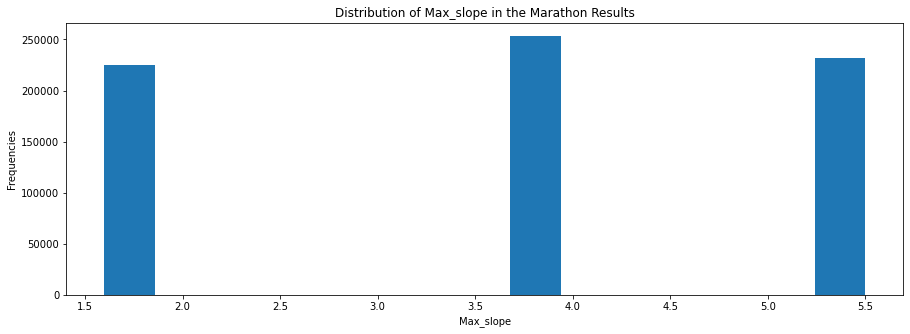

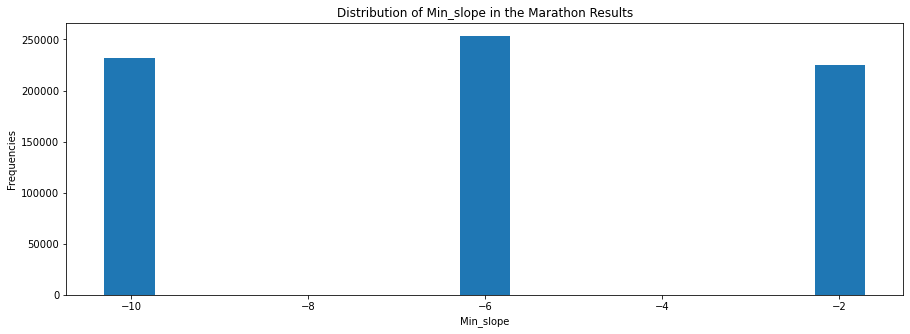

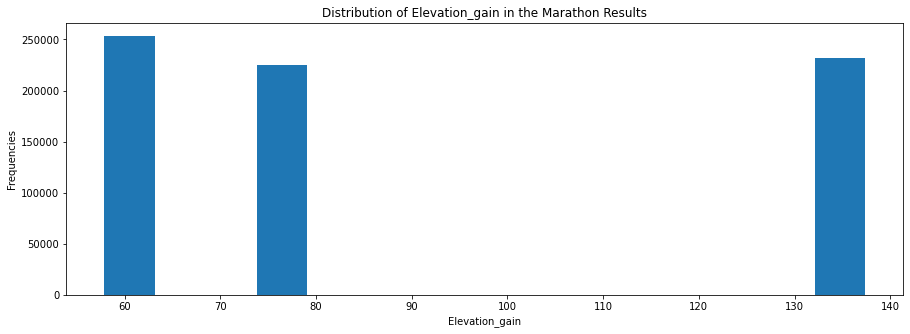

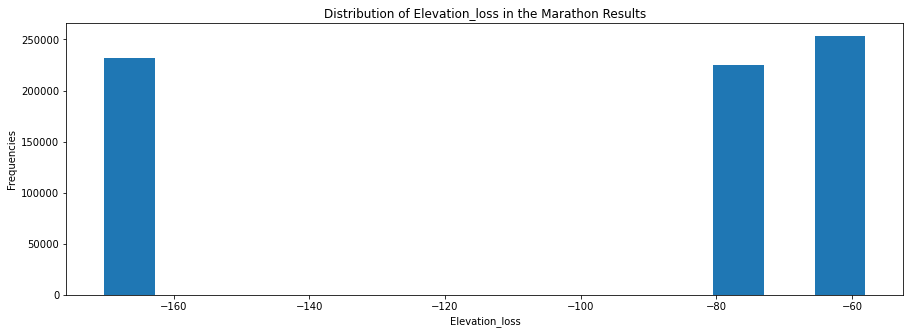

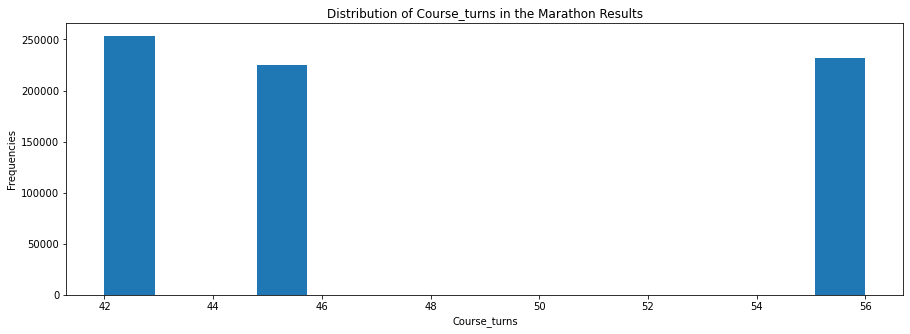

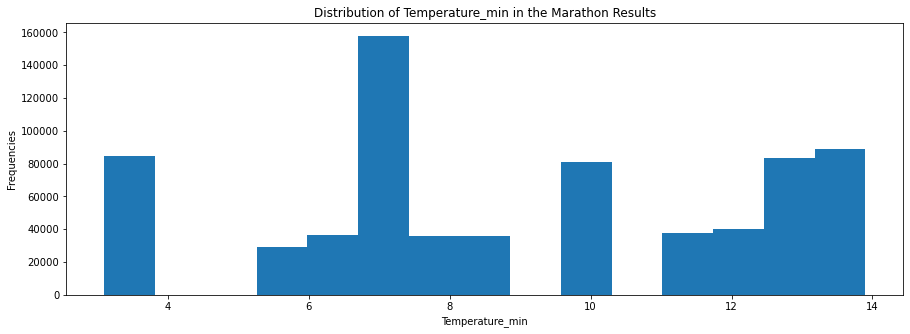

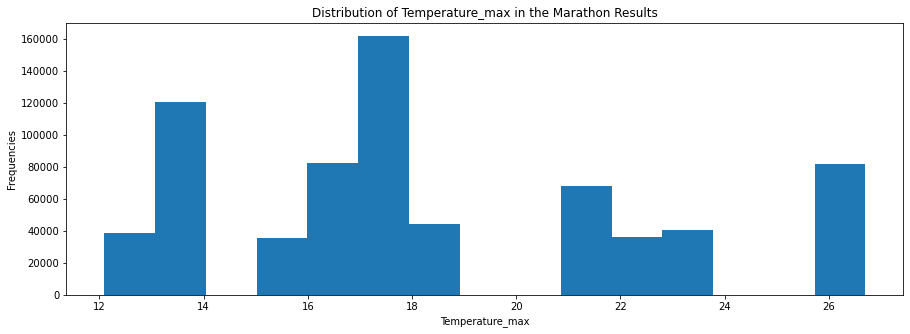

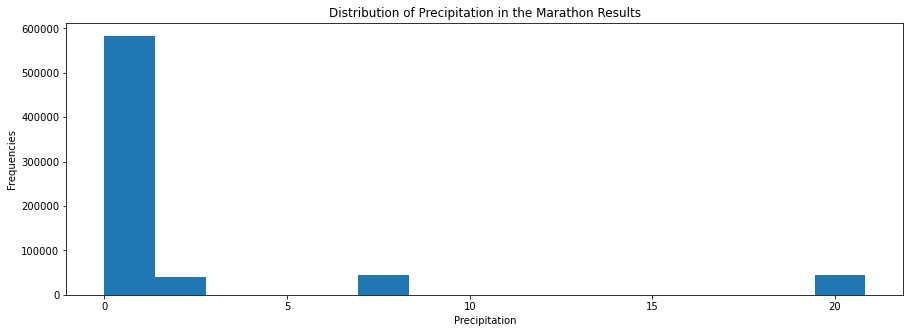

In [14]:
for col in marathon_numeric_columns_df:

    plt.figure(figsize=(15,5))
    plt.hist(marathon_numeric_columns_df[col], bins=15)
    plt.xlabel(col.capitalize())
    plt.ylabel("Frequencies")
    plt.title(f"Distribution of {col.capitalize()} in the Marathon Results")
    plt.show()

In [15]:
marathon_categorical_columns_df = marathon_df[['marathon_name', 'gender', 'nationality']]

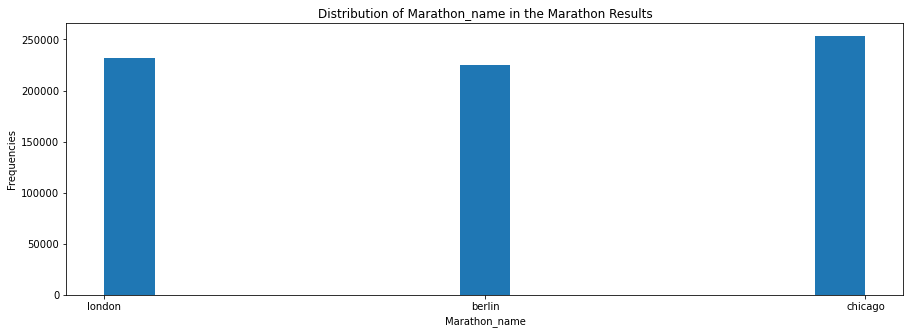

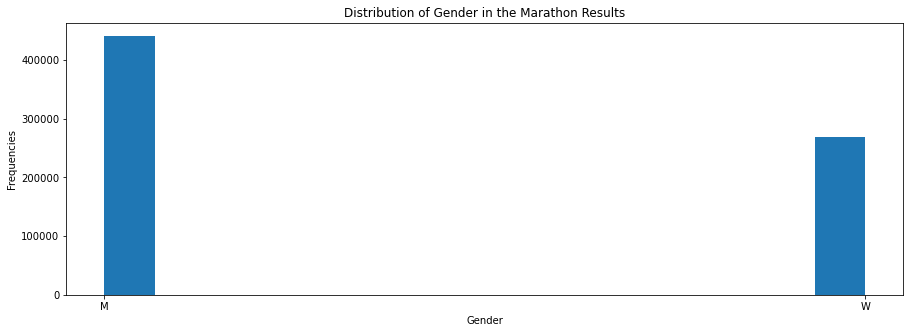

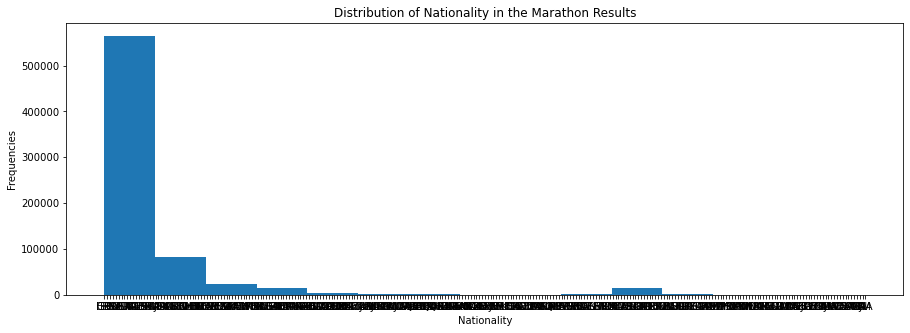

In [16]:
for col in marathon_categorical_columns_df:

    plt.figure(figsize=(15,5))
    plt.hist(marathon_categorical_columns_df[col], bins=15)
    plt.xlabel(col.capitalize())
    plt.ylabel("Frequencies")
    plt.title(f"Distribution of {col.capitalize()} in the Marathon Results")
    plt.show()

#### Take a closer look at the distribution of Nationalities
The plot of the nationalities is very difficult to interpret, as there are so many different countries represented. Take a closer look at this column. 

In [17]:
marathon_df["nationality"].describe()

count     710813
unique       269
top          GBR
freq      220145
Name: nationality, dtype: object

In [18]:
# Return a list of the unique nationality country codes
nationality = marathon_df["nationality"].unique()
nationality.sort()
print(nationality)

['ABW' 'AFG' 'AIA' 'ALA' 'ALB' 'ALG' 'AND' 'ANG' 'ANT' 'ARE' 'ARG' 'ARM'
 'ARU' 'ASA' 'AUS' 'AUT' 'AZE' 'BAH' 'BAN' 'BAR' 'BDI' 'BEL' 'BEN' 'BER'
 'BGR' 'BHS' 'BHU' 'BIH' 'BIZ' 'BLR' 'BOL' 'BOT' 'BRA' 'BRN' 'BRU' 'BUL'
 'BUR' 'CAF' 'CAM' 'CAN' 'CAY' 'CGO' 'CHA' 'CHE' 'CHI' 'CHL' 'CHN' 'CIV'
 'CMR' 'COD' 'COL' 'COM' 'CPV' 'CRC' 'CRI' 'CRO' 'CUB' 'CUW' 'CYP' 'CZE'
 'DEN' 'DEU' 'DJI' 'DMA' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ENG' 'ERI' 'ESA'
 'ESP' 'EST' 'ETH' 'FIJ' 'FIN' 'FLK' 'FRA' 'FRO' 'FSM' 'GAB' 'GAM' 'GBR'
 'GBS' 'GEO' 'GEQ' 'GER' 'GGY' 'GHA' 'GIB' 'GLP' 'GRC' 'GRE' 'GRL' 'GRN'
 'GTM' 'GUA' 'GUI' 'GUM' 'GUY' 'HAI' 'HKG' 'HND' 'HON' 'HRV' 'HUN' 'IDN'
 'IMN' 'INA' 'IND' 'IOT' 'IRI' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR' 'ISV' 'ITA'
 'IVB' 'JAM' 'JEY' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KNA' 'KOR' 'KOS' 'KSA'
 'KUW' 'LAO' 'LAT' 'LBA' 'LBN' 'LBR' 'LBY' 'LCA' 'LES' 'LIB' 'LIE' 'LSO'
 'LTU' 'LUX' 'LVA' 'MAC' 'MAD' 'MAF' 'MAR' 'MAS' 'MAW' 'MDA' 'MDV' 'MEX'
 'MGL' 'MKD' 'MLI' 'MLT' 'MNE' 'MNG' 'MON' 'MRI' 'M

It appears that not all of the marathons used the same country codes and some countries are represented by multiple codes. For instance 'GER' and 'DEU' both represent Germany. I decided to go through each of the country codes and if applicable switch country codes to match the International Olympic Committee country codes. 

In [19]:
# Create a dictionary of the nationality country codes that need to be replaced (Used IOC Country Codes)

ioc_codes = {'DEU' : 'GER', 'ZWE' : 'ZIM', 'ZAF' : 'RSA', 'WLS' : 'GBR', 'WLF' : 'FRA', 'VNM' : 'VIE', 
             'URY' : 'URU', 'UMI' : 'USA', 'ARE' : 'UAE', 'TWN' : 'TPE', 'TRI' : 'TTO', 'TGO' : 'TOG',
             'TCA' : 'GBR', 'SVN' : 'SLO', 'CHE' : 'SUI', 'SDN' : 'SUD', 'SPM' : 'FRA', 'SLV' : 'ESA', 
             'SJM' : 'NOR', 'SIN' : 'SGP', 'SHN' : 'GBR', 'SGS' : 'GBR', 'SCO' : 'GBR', 'RKS' : 'KOS', 
             'REU' : 'FRA', 'PYF' : 'FRA', 'PRI' : 'PUR', 'PAR' : 'PRY', 'PRT' : 'POR', 'PHI' : 'PHL', 
             'OMA' : 'OMN', 'NEP' : 'NPL', 'NLD' : 'NED', 'NGA' : 'NGR', 'NIR' : 'GBR', 'NCL' : 'FRA', 
             'MYT' : 'FRA', 'MYS' : 'MAS', 'MYA' : 'MMR', 'MTQ' : 'FRA', 'MNG' : 'MGL', 'MAF' : 'FRA', 
             'MAC' : 'CHN', 'LVA' : 'LAT', 'LES' : 'LSO', 'LBY' : 'LBA', 'LIB' : 'LBN', 'KNA' : 'SKN', 
             'JEY' : 'GBR', 'IVB' : 'GBR', 'ISV' : 'USA', 'IRN' : 'IRI', 'IOT' : 'GBR', 'IDN' : 'INA', 
             'IMN' : 'GBR', 'HRV' : 'CRO', 'HND' : 'HON', 'GTM' : 'GUA', 'GRL' : 'GRD', 'GRC' : 'GRE', 
             'GLP' : 'FRA', 'GIB' : 'GBR', 'GGY' : 'GBR', 'FRO' : 'DEN' ,'DNK' : 'DEN', 'ENG' : 'GBR',
             'FLK' : 'GBR', 'DZA' : 'ALG', 'CUW' : 'NED', 'CRI' : 'CRC', 'CHL' : 'CHI', 'BGR' : 'BUL',
             'BRN' : 'BRU', 'BHS' : 'BAH', 'ABW' : 'ARU', 'ALA' : 'FIN', 'AIA' : 'GBR'
}

# Update nationality country codes

def update_country_code(original):
    if original in ioc_codes:
        return ioc_codes[original]
    return original

# Replace the above country codes in the nationality column
marathon_df['nationality'] = marathon_df['nationality'].apply(update_country_code)


In [20]:
# Look at the Summary Statistics for the nationality column after cleaning up country codes
marathon_df["nationality"].describe()

count     710813
unique       195
top          GBR
freq      222176
Name: nationality, dtype: object

By removing the duplicate country codes in the `nationality` column, I decreased the number of nationalities from 269 to 195. It should be noted that not all of these columns were duplicated, some countries are not recognized directly by the IOC (for instance the British Overseas Territories) and these were coded to be under their governing territory. 

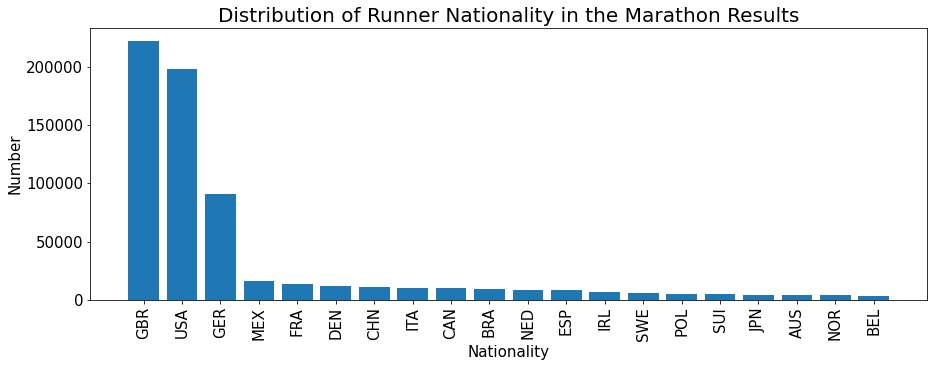

In [112]:
# Re-plot the nationality column

plt.figure(figsize=(15,5))
plt.bar(marathon_df["nationality"].value_counts().head(20).index, marathon_df["nationality"].value_counts().head(20).values)
plt.xlabel('Nationality', size = 15)
plt.ylabel("Number", size = 15)
plt.title('Distribution of Runner Nationality in the Marathon Results', size = 20)
plt.xticks(rotation='vertical', size = 15)
plt.yticks(size = 15)
plt.savefig('Marathon Nationalities.png', dpi=300)
plt.show()

The majority of runners are from the countries in which the races are located: United Kingdom (31.25%), United States (27.9%) and Germany (12.8%). I'm curious to look at the breakdown of nationalities of the top finishers as well as investigating any potential differences in nationality trends between the three marathons. 

#### Look at the nationalities with the average fastest and slowest runners

In [22]:
# Runner nationality by marathon_name
runner_nationality = marathon_df.groupby('nationality')['finish_time_seconds'].agg(['mean', 'std','min', 'max', 'count', 'var'])


# Top 10 countries by mean finish time
runner_nationality.sort_values(by = 'mean').head(10)


,mean,std,min,max,count,var
nationality,,,,,,
ERI,8973.307692,2118.505412,7666,14068,26,4.488065e+06
ETH,9378.768116,2542.787982,7301,20562,138,6.465771e+06
SLE,9576.000000,571.342279,9172,9980,2,3.264320e+05
BDI,10127.400000,1723.664207,8870,12894,5,2.971018e+06
LSO,10192.250000,2707.355952,8680,14248,4,7.329776e+06
LBA,12079.500000,2250.720885,10488,13671,2,5.065744e+06
SUD,12079.916667,2397.052488,8889,16933,12,5.745861e+06
GBS,12250.000000,NaN,12250,12250,1,NaN
SMR,12604.250000,1368.173243,11204,15214,12,1.871898e+06


The nationalities with the fastest average marathon finish time were Eritrea, Ethiopia, Sierra Leone, Burundi, and, Lesotho based on mean finish time. 
Kenya had the fastest minimum finish time of the top 10 nations, although it ranked tenth based on mean finish time. It should be noted that the majority of top nations (based on average mean finish time) were only represented by a few runners. Kenya and Ethopia were represented by more runners relative to the other countries and had a larger range of finish times. 

In [23]:
# Bottom 10 countries based on mean finish time
runner_nationality.sort_values(by = 'mean').tail(10)

,mean,std,min,max,count,var
nationality,,,,,,
QAT,18577.791667,3005.072798,13529,24550,24,9.030463e+06
BAH,18620.890909,3931.471370,10265,26056,55,1.545647e+07
FSM,18635.000000,NaN,18635,18635,1,NaN
INA,18979.066634,3010.598777,10422,30593,2071,9.063705e+06
STP,19034.000000,NaN,19034,19034,1,NaN
SOL,19209.000000,NaN,19209,19209,1,NaN
GRN,19763.000000,4161.049559,13386,26293,8,1.731433e+07
BUR,20024.000000,2341.559224,17514,24064,6,5.482900e+06
LCA,20910.000000,4584.880369,17668,24152,2,2.102113e+07


The countries with the lowest mean finish times were Cambodia,  Saint Lucia, Burma, Grenada, Solomon Islands. However, there were relatively few runners from each of these countries. 

In [24]:
# Look at the finish times of the countries represented by the most runners
runner_nationality.sort_values(by = 'count').tail(10)

,mean,std,min,max,count,var
nationality,,,,,,
BRA,15068.905492,2653.782723,7870,28981,9068,7.042563e+06
CAN,15211.004582,3114.171154,7828,30887,10257,9.698062e+06
ITA,14567.300838,2690.848045,7685,28364,10504,7.240663e+06
CHN,16440.562274,3121.926824,7708,29823,11361,9.746427e+06
DEN,14714.010937,2528.662297,8538,25666,12252,6.394133e+06
FRA,14396.168727,2611.392880,7990,31487,13916,6.819373e+06
MEX,15917.597390,3000.703607,8094,41107,16398,9.004222e+06
GER,15221.282954,2560.422640,7970,31639,91195,6.555764e+06
USA,16841.514085,3534.275099,7581,35400,198366,1.249110e+07


The table above shows the differences in finish times for the countries represented by the most runners. The average finish time for runners from the UK is approximately 4.5 hours. 

#### Investigate the mean finish time for each marathon
NOTE: this includes all finish times across all years. Outliers have not been addressed at this point. 

In [25]:
# Look at the mean, standard deviation and variance in finish times for each marathon
marathon_df.groupby('marathon_name')['finish_time_seconds'].agg(['mean', 'std', 'var', 'count'])


,mean,std,var,count
marathon_name,,,,
berlin,15034.273330,2749.381564,7.559099e+06,225486
chicago,16536.336191,3500.913766,1.225640e+07,253365
london,16311.810728,3610.471273,1.303550e+07,231962


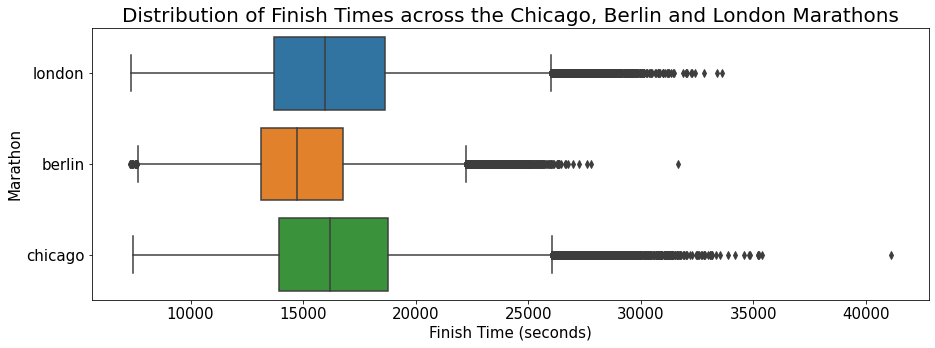

In [110]:
# Create a box plot to visualize these differences

plt.figure(figsize = (15,5))
sns.boxplot(y='marathon_name', x='finish_time_seconds', data=marathon_df, orient="h")
plt.ylabel("Marathon", size = 15)
plt.xlabel("Finish Time (seconds)", size = 15)
plt.title("Distribution of Finish Times across the Chicago, Berlin and London Marathons", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.savefig('Marathon Finish Times.png', dpi=300)
plt.show()

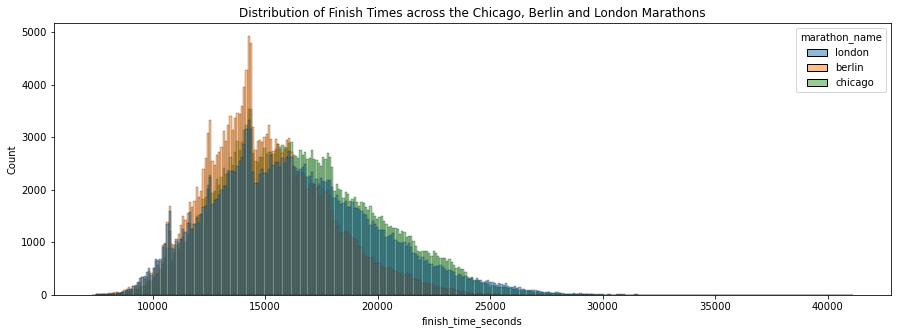

In [27]:
# Plot distribution of finish time as a histogram for the three marathons
plt.figure(figsize = (15,5))
sns.histplot(x = 'finish_time_seconds', hue = 'marathon_name', data = marathon_df)
plt.title("Distribution of Finish Times across the Chicago, Berlin and London Marathons")
plt.show()

It appears that the mean finish time for Berlin is slightly faster vs. London and Chicago. I will use ANOVA to see if this difference is significant. I recognize that there are differences in the standard deviations and the variances in the finish times between the three marathons which is a violation of an assumption for ANOVA. That being said, the largest standard deviation is less than double the smallest standard deviation, the sample sizes are large and follow nearly normal distributions (there is some right skewness). Thus, I will proceed with ANOVA. The null hypothesis ($H_0$) is that there is no difference between the three marathons for mean average finish time. The alternative hypothesis ($H_1$) is that there is some difference between the means of the groups. 

In [28]:
# Set up the data for ANOVA

anova_data = {}
marathons = marathon_df["marathon_name"].unique()

# get the finish times for each marathon
for marathon in marathons:
    anova_data[marathon] = marathon_df.loc[marathon_df["marathon_name"] == marathon, "finish_time_seconds"]
    

In [29]:
# Look at chicago anova_data
anova_data['chicago']

457448     7545
457449     7546
457450     7548
457451     7553
457452     7574
          ...  
710808    29300
710809    29513
710810    29808
710811    29949
710812    30219
Name: finish_time_seconds, Length: 253365, dtype: int64

In [30]:
# Add data in as separate arguments

stats.f_oneway(anova_data["chicago"], 
               anova_data["london"], 
               anova_data["berlin"])

F_onewayResult(statistic=13865.058452314717, pvalue=0.0)

As the p value (0.0) is less than the significance threshold of 0.05, the null hypothesis is rejected and it can be stated that at least one of the marathon mean finish times is different from the others. Tukey's Honestly Significant Difference (HSD) Test will be used to calculate all pairwise comparisons. Tukey's HSD takes care of correcting for multiple comparisons. 

In [31]:
# Use ukey's Honestly Significant Difference test

multicomp.pairwise_tukeyhsd(marathon_df['finish_time_seconds'], marathon_df['marathon_name']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
berlin,chicago,1502.0629,0.001,1479.5375,1524.5883,True
berlin,london,1277.5374,0.001,1254.5278,1300.5469,True
chicago,london,-224.5255,0.001,-246.8839,-202.1671,True


The differences in mean finish times between the Chicago, Berlin and London marathons are all significantly different. 


Some of the observed differences may be attributed to how the marathons accept runners. Each marathon includes elite and sub-elite entry options  based on qualifying times (age based). Further, each marathon offers a non-guaranteed lottery option where runners apply and are then drawn at random. Chicago and London also include charity entry options where by you can run as part of a fundraising initiative. Each marathon also includes an option to secure an entry through an approved International tour group partner (although this is not available for all countries). Information on the exact number of runners admitted to each race per year based on guaranteed (qualifying standards, Charity and International Tour options) vs. non-guaranteed entry routes (lottery) was not publically available. The Chicago marathon indicated that the number of non-guaranteed/lottery entries varies each year depending on the number of runners admitted via the guaranteed entry options (https://www.chicagomarathon.com/apply/frequently-asked-application-questions/). Entry route may be a contributing factor to the differences in mean finish times, but without an exact breakdown of the number of runners admitted by each entry option for each marathon (and each year) it is impossible to definitively say. 

Information on the entry options for the marathons was obtained from: 
https://www.chicagomarathon.com/apply
https://www.tcslondonmarathon.com/enter/how-to-enter/ballot-entry
https://www.bmw-berlin-marathon.com/en/your-registration/lottery/

#### Finish time by year for each of the marathons

In [32]:
# Look at the mean, standard deviation and variance in finish times for each year of each marathon
marathon_year_mean_finish_time = marathon_df.groupby(['marathon_name', 'year'])['finish_time_seconds'].agg(['mean', 'std', 'var', 'count'])
marathon_year_mean_finish_time.reset_index(inplace = True)
marathon_year_mean_finish_time

,marathon_name,year,mean,std,var,count
0,berlin,2014,14869.664582,2619.074865,6.859553e+06,28943
1,berlin,2015,14830.948902,2654.383464,7.045752e+06,36753
2,berlin,2016,14626.095111,2236.708793,5.002866e+06,36000
3,berlin,2017,15136.335365,2776.067119,7.706549e+06,39220
4,berlin,2018,15539.874585,3011.338956,9.068162e+06,40641
5,berlin,2019,15088.462041,2929.112545,8.579700e+06,43929
6,chicago,2014,16386.189267,3317.576137,1.100631e+07,40604
7,chicago,2015,16467.468618,3233.384021,1.045477e+07,37442
8,chicago,2016,16486.844191,3425.022580,1.173078e+07,40556
9,chicago,2017,17238.877289,3688.589278,1.360569e+07,44348


There appear to be differences in the mean finish times across years for each marathon. This will be explored further below. Interestingly, the numbers of participants in each marathon have increased from 2014 to 2015. 

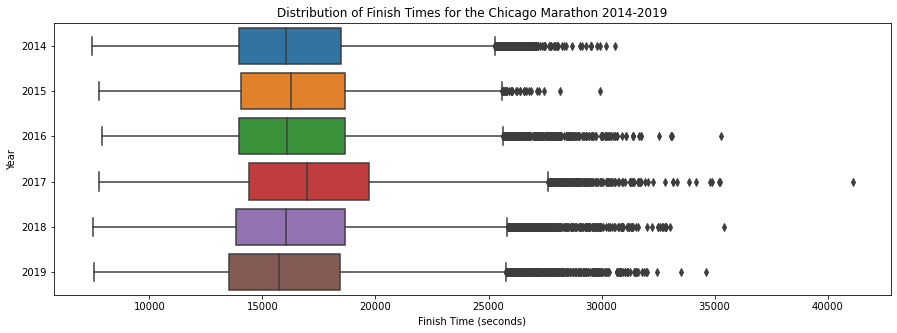

In [33]:
# Create a box plot to visualize the differences in finish times per year for the Chicago Marathon

tmp_df_chicago = marathon_df[marathon_df['marathon_name']=='chicago']
plt.figure(figsize = (15,5))
sns.boxplot(y='year', x='finish_time_seconds', data=tmp_df_chicago, orient="h")
plt.ylabel("Year")
plt.xlabel("Finish Time (seconds)")
plt.title("Distribution of Finish Times for the Chicago Marathon 2014-2019")
plt.show()

There appear to be differences in the mean and median finish times. 2017 in particular appears to be higher, although there is one extreme outlier with a finish time greater than 12 hours. This point should be investigated further and potentially removed. For the Chicago Marathon results, all outliers appear to be at the upper end of finish times, these outliers may need to be removed for model improvement.

In [34]:
# Set up the data for ANOVA to detect differences in finish times between the years for Chicago

anova_data_chicago = {}
years = tmp_df_chicago["year"].unique()

# get the finish times for each marathon
for year in years:
    anova_data_chicago[year] = tmp_df_chicago.loc[tmp_df_chicago["year"] == year, "finish_time_seconds"]

# Look at 2014 anova_data
anova_data_chicago[2014]
    

670209     7451
670210     7468
670211     7472
670212     7551
670213     7710
          ...  
710808    29300
710809    29513
710810    29808
710811    29949
710812    30219
Name: finish_time_seconds, Length: 40604, dtype: int64

In [35]:
# Add data in as separate arguments to one-way anova

stats.f_oneway(anova_data_chicago[2014], 
               anova_data_chicago[2015], 
               anova_data_chicago[2016],
               anova_data_chicago[2017],
               anova_data_chicago[2018], 
               anova_data_chicago[2019])

F_onewayResult(statistic=480.3622868024668, pvalue=0.0)

In [36]:
# Use ukey's Honestly Significant Difference test to look at all pair wise comparisons

multicomp.pairwise_tukeyhsd(tmp_df_chicago['finish_time_seconds'], tmp_df_chicago['year']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
2014,2015,81.2794,0.0144,10.1341,152.4246,True
2014,2016,100.6549,0.001,30.9452,170.3647,True
2014,2017,852.688,0.001,784.4856,920.8905,True
2014,2018,51.9556,0.2502,-16.1729,120.0841,False
2014,2019,-200.8738,0.001,-268.535,-133.2126,True
2015,2016,19.3756,0.9,-51.7899,90.541,False
2015,2017,771.4087,0.001,701.719,841.0983,True
2015,2018,-29.3237,0.8157,-98.941,40.2935,False
2015,2019,-282.1532,0.001,-351.3132,-212.9931,True
2016,2017,752.0331,0.001,683.8096,820.2566,True


Based on the ANOVA and Tukey's HSD the mean finish times for 2017 and 2019 are significantly different from all other race years (at a significance level of 0.05). The mean finish times for 2017 appear to be higher, while the mean finish times for 2019 appear to be lower. 

The following years were not different from each other (at a significance level of 0.05): 
- 2014 and 2018
- 2015 and 2016
- 2015 and 2018
- 2016 and 2018

The weather data (precipitation, minimum temperature, and maximum temperatures for each year will be explored below. 

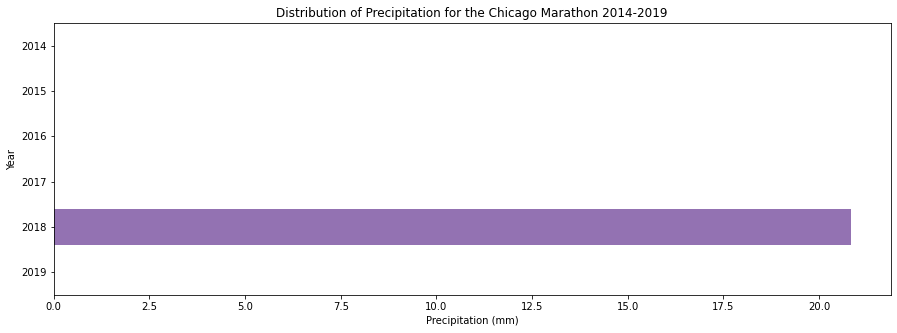

In [37]:
# Create a bar plot to visualize the differences in precipitaiton per year for the Chicago Marathon

tmp_df_chicago = marathon_df[marathon_df['marathon_name']=='chicago']
plt.figure(figsize = (15,5))
sns.barplot(y='year', x='precipitation', data=tmp_df_chicago, orient="h")
plt.ylabel("Year")
plt.xlabel("Precipitation (mm)")
plt.title("Distribution of Precipitation for the Chicago Marathon 2014-2019")
plt.show()

The only precipitation recorded during 2014-2019 for the Chicago Marathon was in 2018 and that did not appear to influence median finish times. I'll next look at the maximum and minimum temperatures to see if those potentially contributed to the increased median finish times in 2017. 

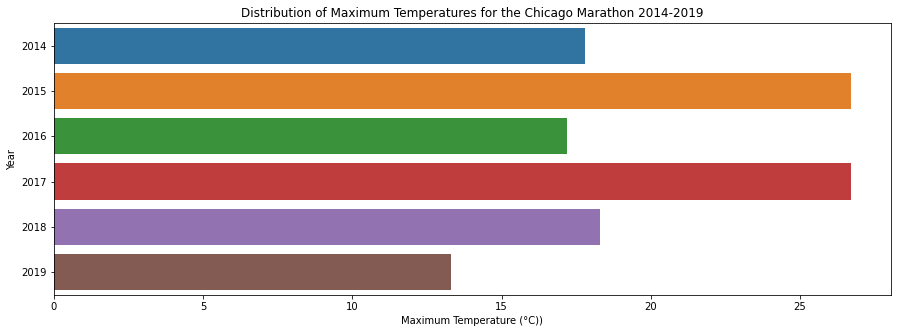

In [38]:
# Create a bar plot to visualize the differences in maximum temperatures per year for the Chicago Marathon

tmp_df_chicago = marathon_df[marathon_df['marathon_name']=='chicago']
plt.figure(figsize = (15,5))
sns.barplot(y='year', x='temperature_max', data=tmp_df_chicago, orient="h")
plt.ylabel("Year")
plt.xlabel("Maximum Temperature (°C))")
plt.title("Distribution of Maximum Temperatures for the Chicago Marathon 2014-2019")
plt.show()

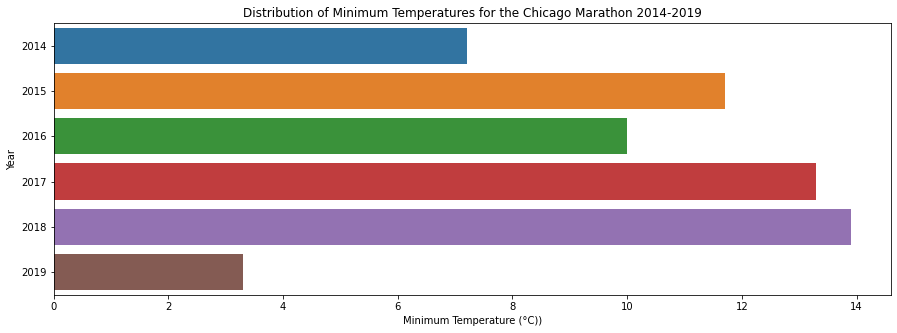

In [39]:
# Create a bar plot to visualize the differences in minimum temperatures per year for the Chicago Marathon

tmp_df_chicago = marathon_df[marathon_df['marathon_name']=='chicago']
plt.figure(figsize = (15,5))
sns.barplot(y='year', x='temperature_min', data=tmp_df_chicago, orient="h")
plt.ylabel("Year")
plt.xlabel("Minimum Temperature (°C))")
plt.title("Distribution of Minimum Temperatures for the Chicago Marathon 2014-2019")
plt.show()

Both 2015 and 2017 had higher maximum temperatures (> 25°C) compared to the other years. It is possible that the higher temperature contributed to greater mean finish times for 2017, but this effect was not observed in 2015. The minimum temperature, while in the higher end of the range, did not appear to be different from other years. High temperatures can negatively impact finish times by increasing the perspiration (and consequently dehydration) and perceived effort of runners. Higher maximum temperatures are likely to have a greater impact on slower runners, as slower runners generally start (and finish) the marathon later than the faster runners. 2019 was a much cooler year with a minimum temperature of 3.3°C and a maximum temperature of 13.3°C. It is possible that the cooler temperatures were a contributing factor to the lower mean finish time. 

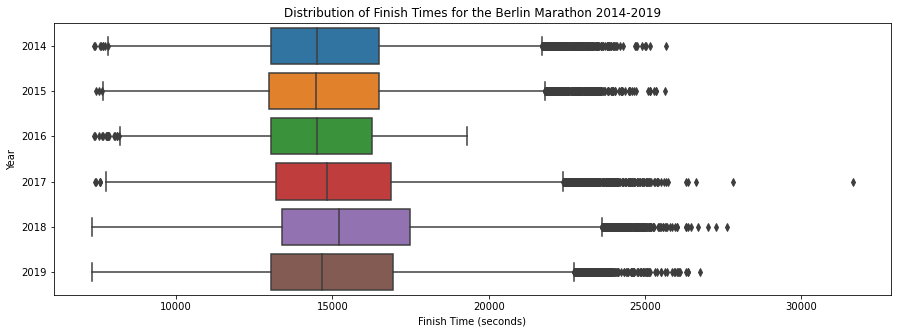

In [40]:
# Create a bar plot to visualize the differences in finish times per year for the Berlin Marathon

tmp_df_berlin = marathon_df[marathon_df['marathon_name']=='berlin']
plt.figure(figsize = (15,5))
sns.boxplot(y='year', x='finish_time_seconds', data=tmp_df_berlin, orient="h")
plt.ylabel("Year")
plt.xlabel("Finish Time (seconds)")
plt.title("Distribution of Finish Times for the Berlin Marathon 2014-2019")
plt.show()

Berlin is the only marathon that appears to have outliers at the lower end of the finish times. Interestingly, there did not appear to be any outliers for 2016. The mean and median finish times appear to be higher for 2017 and 2018. An ANOVA and Tukeys HSD will be run below to detect any potential differences between the years. 

In [41]:
# Set up the data for ANOVA to detect differences in finish times between the years for Berlin

anova_data_berlin = {}
years = tmp_df_berlin["year"].unique()

# get the finish times for each marathon
for year in years:
    anova_data_berlin[year] = tmp_df_berlin.loc[tmp_df_berlin["year"] == year, "finish_time_seconds"]
    
# Look at 2014 anova_data
anova_data_berlin[2014]
    

268715     7377
268716     7393
268717     7556
268718     7599
268719     7648
          ...  
297653    24888
297654    25011
297655    25025
297656    25165
297657    25666
Name: finish_time_seconds, Length: 28943, dtype: int64

In [42]:
# Add data in as separate arguments to one-way anova

stats.f_oneway(anova_data_berlin[2014], 
               anova_data_berlin[2015], 
               anova_data_berlin[2016],
               anova_data_berlin[2017],
               anova_data_berlin[2018], 
               anova_data_berlin[2019])

F_onewayResult(statistic=514.538622556431, pvalue=0.0)

The p value (0.0) for the one way ANOVA was significant, indicating that there were differences in finish times between the years. 

In [43]:
# Use ukey's Honestly Significant Difference test to look at all pair wise comparisons

multicomp.pairwise_tukeyhsd(tmp_df_berlin['finish_time_seconds'], tmp_df_berlin['year']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
2014,2015,-38.7157,0.4658,-99.9402,22.5089,False
2014,2016,-243.5695,0.001,-305.0755,-182.0635,True
2014,2017,266.6708,0.001,206.3005,327.0411,True
2014,2018,670.21,0.001,610.2895,730.1305,True
2014,2019,218.7975,0.001,159.8171,277.7778,True
2015,2016,-204.8538,0.001,-262.6238,-147.0838,True
2015,2017,305.3865,0.001,248.8272,361.9457,True
2015,2018,708.9257,0.001,652.8468,765.0046,True
2015,2019,257.5131,0.001,202.4399,312.5864,True
2016,2017,510.2403,0.001,453.3764,567.1041,True


All pair wise comparisons except for 2014-2015 and 2017-2019 were significantly different (at a significance threshold of 0.05). 
Precipitation, maximum and minimum temperatures for each year will be explored below to try and understand the observed differences. 

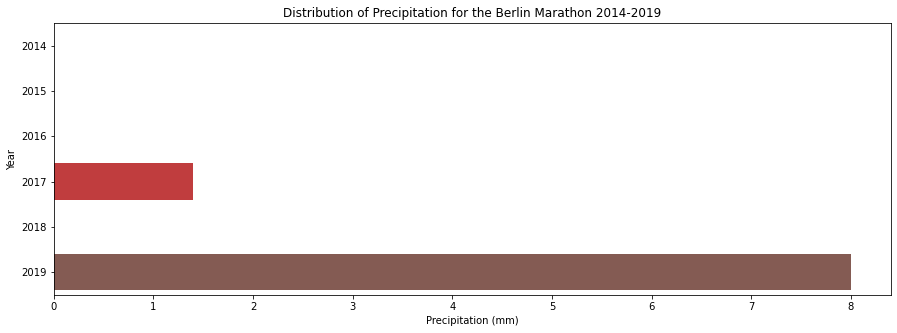

In [44]:
# Create a bar plot to visualize the differences in precipitaiton per year for the Berlin Marathon

tmp_df_berlin = marathon_df[marathon_df['marathon_name']=='berlin']
plt.figure(figsize = (15,5))
sns.barplot(y='year', x='precipitation', data=tmp_df_berlin, orient="h")
plt.ylabel("Year")
plt.xlabel("Precipitation (mm)")
plt.title("Distribution of Precipitation for the Berlin Marathon 2014-2019")
plt.show()

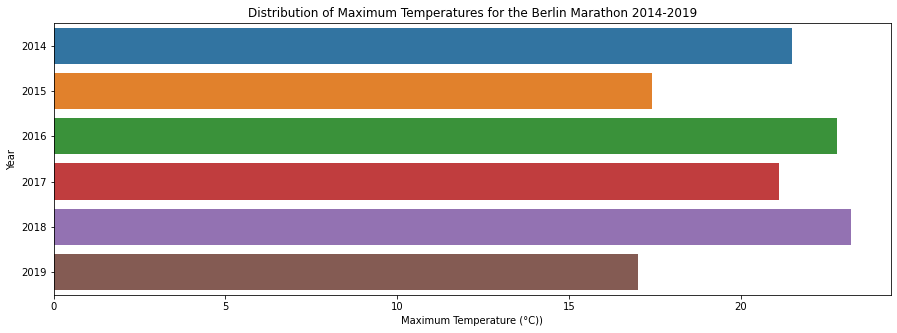

In [45]:
# Create a bar plot to visualize the differences in maximum temperatures per year for the Berlin Marathon

tmp_df_berlin = marathon_df[marathon_df['marathon_name']=='berlin']
plt.figure(figsize = (15,5))
sns.barplot(y='year', x='temperature_max', data=tmp_df_berlin, orient="h")
plt.ylabel("Year")
plt.xlabel("Maximum Temperature (°C))")
plt.title("Distribution of Maximum Temperatures for the Berlin Marathon 2014-2019")
plt.show()

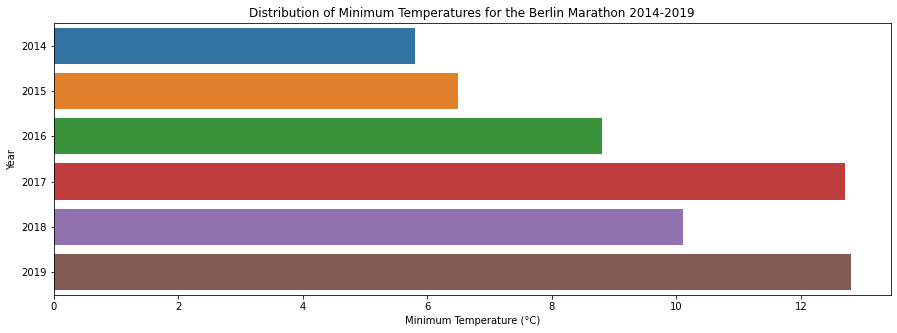

In [46]:
# Create a bar plot to visualize the differences in minimum temperatures per year for the Berlin Marathon

tmp_df_berlin = marathon_df[marathon_df['marathon_name']=='berlin']
plt.figure(figsize = (15,5))
sns.barplot(y='year', x='temperature_min', data=tmp_df_berlin, orient="h")
plt.ylabel("Year")
plt.xlabel("Minimum Temperature (°C)")
plt.title("Distribution of Minimum Temperatures for the Berlin Marathon 2014-2019")
plt.show()

2018 had the highest maximum temperature (23.2°C), which could have contributed to the higher mean finish times. Interestingly, Eliud Kipchoge broke the marathon world record in this race (with a finish time of 2:01:39). As he was an elite runner, he would have finished his marathon hours before the maximum temperature was reached, unlike the majority of the other runners. It is difficult to fully attribute the higher mean finish times in 2018 to temperature as 2016 had a high maximum temperature (22.8°C) without any apparent effect on finish times. 

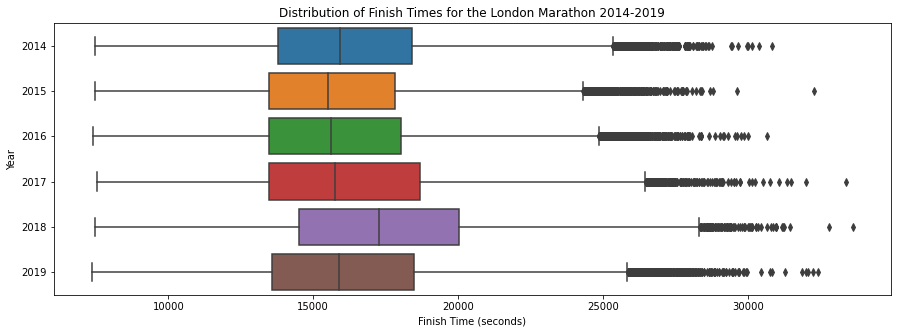

In [48]:
# Create a box plot to visualize the differences in finish times per year for the London Marathon

tmp_df_london = marathon_df[marathon_df['marathon_name']=='london']
plt.figure(figsize = (15,5))
sns.boxplot(y='year', x='finish_time_seconds', data=tmp_df_london, orient="h")
plt.ylabel("Year")
plt.xlabel("Finish Time (seconds)")
plt.title("Distribution of Finish Times for the London Marathon 2014-2019")
plt.show()

There do appear to be a number of outliers towards the high end of the finishing times for the London Marathon. The median finish time in 2018 appeared to be greater compared to the other years. 

In [49]:
# Set up the data for ANOVA to detect differences in finish times between the years for London

anova_data_london = {}
years = tmp_df_london["year"].unique()

# get the finish times for each marathon
for year in years:
    anova_data_london[year] = tmp_df_london.loc[tmp_df_london["year"] == year, "finish_time_seconds"]
    
# Look at 2014 anova_data
anova_data_london[2014]

119972    8187
119973    8206
119974    8399
119975    8454
119976    8576
          ... 
155783    8818
155784    9120
155785    9181
155786    9260
155787    9365
Name: finish_time_seconds, Length: 35816, dtype: int64

In [50]:
# Add data in as separate arguments to one-way anova

stats.f_oneway(anova_data_london[2014], 
               anova_data_london[2015], 
               anova_data_london[2016],
               anova_data_london[2017],
               anova_data_london[2018], 
               anova_data_london[2019])

F_onewayResult(statistic=1017.4432489193862, pvalue=0.0)

In [51]:
# Use ukey's Honestly Significant Difference test to look at all pair wise comparisons

multicomp.pairwise_tukeyhsd(tmp_df_london['finish_time_seconds'], tmp_df_london['year']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
2014,2015,-443.9804,0.001,-519.2083,-368.7524,True
2014,2016,-298.5612,0.001,-373.0915,-224.0309,True
2014,2017,-70.8582,0.0792,-146.1695,4.4531,False
2014,2018,1167.2926,0.001,1093.2747,1241.3105,True
2014,2019,-49.3887,0.3864,-122.3992,23.6218,False
2015,2016,145.4192,0.001,71.7338,219.1046,True
2015,2017,373.1222,0.001,298.6469,447.5974,True
2015,2018,1611.273,0.001,1538.1059,1684.44,True
2015,2019,394.5917,0.001,322.4439,466.7394,True
2016,2017,227.703,0.001,153.9325,301.4735,True


All pair wise comparisons except for 2014-2017, 2014-2019, and 2017-2019 were significantly different at the 0.05 level. This confirmed that the mean finish times for 2018 were greater compared to the other years. I'll investigate the yearly temperatures for London below to see if there are any noticeable differences that could possibly explain the increased median finish time for 2018. There was no precipiation recorded for 2014-2019 for the London Marathon, so precipitation will be not be explored. 

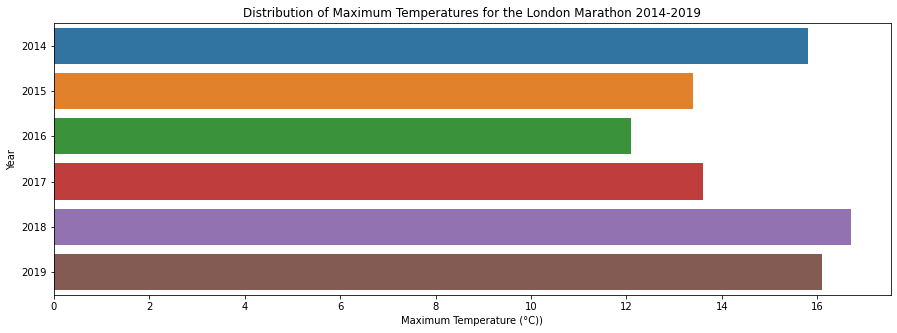

In [52]:
# Create a bar plot to visualize the differences in maximum temperatures per year for the London Marathon

tmp_df_london = marathon_df[marathon_df['marathon_name']=='london']
plt.figure(figsize = (15,5))
sns.barplot(y='year', x='temperature_max', data=tmp_df_london, orient="h")
plt.ylabel("Year")
plt.xlabel("Maximum Temperature (°C))")
plt.title("Distribution of Maximum Temperatures for the London Marathon 2014-2019")
plt.show()

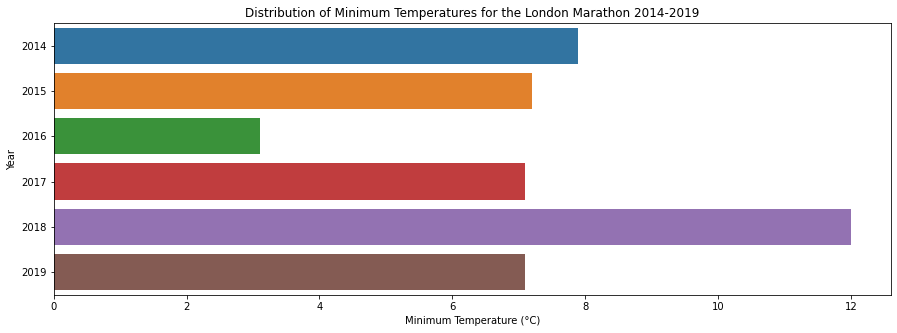

In [53]:
# Create a bar plot to visualize the differences in minimum temperature per year for the London Marathon

tmp_df_london = marathon_df[marathon_df['marathon_name']=='london']
plt.figure(figsize = (15,5))
sns.barplot(y='year', x='temperature_min', data=tmp_df_london, orient="h")
plt.ylabel("Year")
plt.xlabel("Minimum Temperature (°C)")
plt.title("Distribution of Minimum Temperatures for the London Marathon 2014-2019")
plt.show()

2018 had the highest minimum and maximum temperatures of all the years. The minimum temperature for 2018 was 12°C vs 7-8°C for all other years. It is possible that the warmer starting temperature in 2018 resulted in higher mean temperatures compared to the other years. 

#### Investigate the differences in finish times between male and female runners

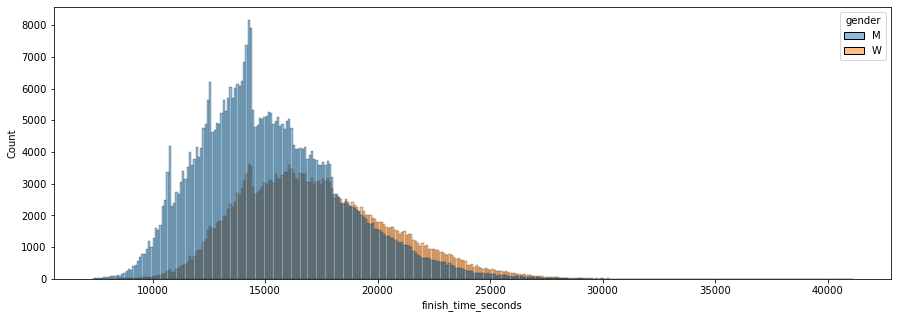

In [54]:
# Plot the finish times by gender
plt.figure(figsize = (15,5))
finish_time_gender = marathon_df[['finish_time_seconds', 'gender']]
sns.histplot(x = 'finish_time_seconds', hue = 'gender', data=finish_time_gender)
plt.show()

#### Investigate relationships (correlations) between features

In [55]:
# Lets get the correlation matrix and save to variable 'corr_mat'
corr_mat = marathon_df.corr()

# Display corr_mat
corr_mat

,year,place_overall,elite_status,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,course_turns,temperature_min,temperature_max,precipitation
year,1.000000,0.019740,0.002658,0.031472,-0.012093,-0.007409,-0.027501,0.026544,-0.011213,0.013153,-0.011971,0.241478,-0.122468,0.333513
place_overall,0.019740,1.000000,-0.055261,0.922484,0.151701,0.128212,0.139313,-0.126265,-0.011268,-0.003176,-0.005685,-0.025309,-0.049152,0.022641
elite_status,0.002658,-0.055261,1.000000,-0.073980,-0.006636,-0.005761,-0.005205,0.004630,0.001149,-0.000560,0.000922,0.000947,-0.001423,0.001800
finish_time_seconds,0.031472,0.922484,-0.073980,1.000000,0.125843,0.098862,0.159284,-0.148682,0.022946,-0.037032,0.028413,0.050552,-0.000422,0.004479
altitude_start,-0.012093,0.151701,-0.006636,0.125843,1.000000,0.985341,0.100839,-0.010683,-0.678155,0.622280,-0.656963,0.178711,0.245816,0.247648
altitude_finish,-0.007409,0.128212,-0.005761,0.098862,0.985341,1.000000,-0.070366,0.160060,-0.793589,0.746700,-0.775949,0.225170,0.335163,0.268839
max_slope,-0.027501,0.139313,-0.005205,0.159284,0.100839,-0.070366,1.000000,-0.995923,0.662788,-0.716055,0.683832,-0.268205,-0.517290,-0.119783
min_slope,0.026544,-0.126265,0.004630,-0.148682,-0.010683,0.160060,-0.995923,1.000000,-0.727632,0.776102,-0.746861,0.285767,0.542197,0.142843
elevation_gain,-0.011213,-0.011268,0.001149,0.022946,-0.678155,-0.793589,0.662788,-0.727632,1.000000,-0.997293,0.999595,-0.332624,-0.567125,-0.274872
elevation_loss,0.013153,-0.003176,-0.000560,-0.037032,0.622280,0.746700,-0.716055,0.776102,-0.997293,1.000000,-0.998982,0.336412,0.579476,0.268000


The above correlation matrix is difficult to interpret. Plot as a heat map to more easily visualize higher correlations. 

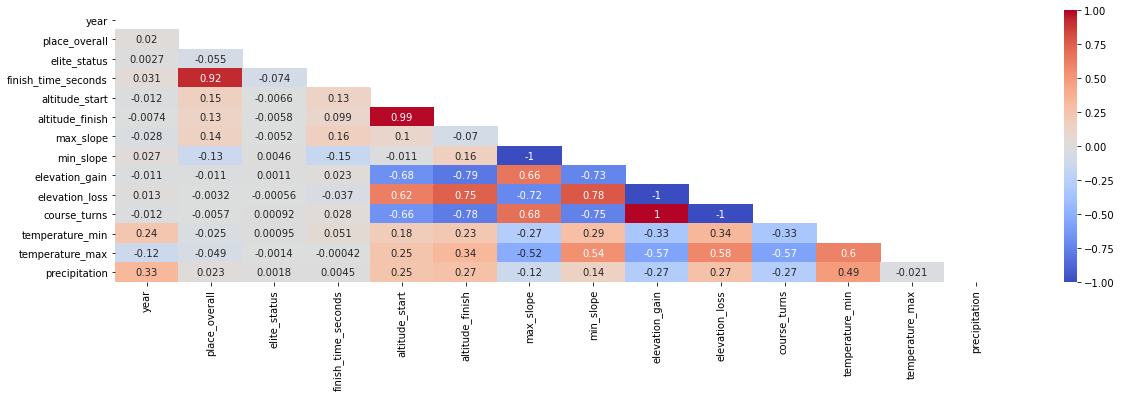

In [56]:
# Create a correlation heatmap
plt.figure(figsize=(20,5))

# creating mask of duplicated combinations
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
sns.heatmap(corr_mat, mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True)
plt.show()

This correlation heat map indicates some instances of correlation between independent variables that will potentially need to be addressed. In particular several of the course features appear to be highly correlated. 
Correlations to pay attention to: 
- place_overall is highly correlated with finish_time_seconds - not surpisingly since place is dependent on finish time
- altitude at start and finish
- max slope and min slope
- elevation gain and elevation loss
- course turns and elevation loss
- course turns and elevation gain

#### Try a preliminary linear regression model using only the numerical features

In [57]:
marathon_numeric_columns_df.columns

Index(['year', 'place_overall', 'finish_time_seconds', 'elite_status',
       'altitude_start', 'altitude_finish', 'max_slope', 'min_slope',
       'elevation_gain', 'elevation_loss', 'course_turns', 'temperature_min',
       'temperature_max', 'precipitation'],
      dtype='object')

In [58]:
X_0 = marathon_numeric_columns_df.drop('finish_time_seconds', axis = 1)
y_0 = marathon_numeric_columns_df['finish_time_seconds']

In [59]:
# First, divide data into remainder, and test sets
# Take 20% for the test set

X_0_train, X_0_test, y_0_train, y_0_test = \
    train_test_split(X_0, y_0, test_size = 0.2,
                     random_state=1)

In [60]:
# Create linear regression object
prelim_marathon_regr_0 = linear_model.LinearRegression()

# Train the model using the training sets
prelim_marathon_regr_0.fit(X_0_train, y_0_train)

# Make predictions using the testing set
prelim_marathon_y_pred = prelim_marathon_regr_0.predict(X_0_test)

# The coefficients
print("Coefficients: \n", prelim_marathon_regr_0.coef_)
# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_0_test, prelim_marathon_y_pred))


# The coefficient of determination: 1 is perfect prediction

print("Coefficient of determination: %.2f" % r2_score(y_0_test, prelim_marathon_y_pred))

# Score the model 
prelim_marathon_regr_0.score(X_0_test, y_0_test)


Coefficients: 
 [ 1.91233663e+01  2.68862961e-01 -2.27385888e+03  1.50010896e+00
 -4.17376143e-03  1.97001994e-01 -4.29009747e-01  2.60386788e+00
 -4.10815060e+00  4.79254462e-01  1.14481406e+02  1.58569987e+01
 -3.72653102e+01]
Mean absolute error: 753.43
Coefficient of determination: 0.86


0.8632579832941447

This preliminary model only uses the following features: 
- year, place_overall, finish_time_seconds, elite_status, altitude_start, altitude_finish, max_slope, min_slope, elevation_gain, elevation_loss, course_turns, temperature_min, temperature_max, precipitation

This preliminary model returned an R-Squared value of 0.86 and a mean absolute error of 754.43 seconds (12.5 minutes). While this is not a terrible benchmark for using a relatively small number of features, there are several issues with this model: 
- place_overall is determined by finish time, therefore it is not useful as a predictor, and will be dropped before proceeding with additional models. 
- if moving forward with linear regression models, the multi-collinarity identified above needs to be addressed

As a next step, some non-numeric features will be transformed to numeric before proceeding with modelling. 

### Data Transformation
- To Do List: 
    - Binarize the gender column
    - One Hot Encode the Nationality column
    - One Hot Encode the Nationality column
    - Drop columns that will not be used for modelling

#### Binarize the gender column

In [61]:
# Convert the gender column to binary 
# Male -> 0
# Female -> 1

marathon_df['gender'] = marathon_df['gender'].apply(lambda x: 0 if x == 'M' else 1)

# Confirm that the gender column has been converted to binary

marathon_df['gender'].describe()

count    710813.000000
mean          0.379174
std           0.485182
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: gender, dtype: float64

#### One Hot Encode the Nationality Column

In [62]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
runner_nationality = pd.DataFrame(marathon_df['nationality'])
encoded_runner_nationality = ohe.fit_transform(runner_nationality)
encoded_runner_nationality

<710813x195 sparse matrix of type '<class 'numpy.float64'>'
	with 710813 stored elements in Compressed Sparse Row format>

In [63]:
dense_array = encoded_runner_nationality.toarray()
dense_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
ohe.categories_

[array(['AFG', 'ALB', 'ALG', 'AND', 'ANG', 'ANT', 'ARG', 'ARM', 'ARU',
        'ASA', 'AUS', 'AUT', 'AZE', 'BAH', 'BAN', 'BAR', 'BDI', 'BEL',
        'BEN', 'BER', 'BHU', 'BIH', 'BIZ', 'BLR', 'BOL', 'BOT', 'BRA',
        'BRU', 'BUL', 'BUR', 'CAF', 'CAM', 'CAN', 'CAY', 'CGO', 'CHA',
        'CHI', 'CHN', 'CIV', 'CMR', 'COD', 'COL', 'COM', 'CPV', 'CRC',
        'CRO', 'CUB', 'CYP', 'CZE', 'DEN', 'DJI', 'DMA', 'DOM', 'ECU',
        'EGY', 'ERI', 'ESA', 'ESP', 'EST', 'ETH', 'FIJ', 'FIN', 'FRA',
        'FSM', 'GAB', 'GAM', 'GBR', 'GBS', 'GEO', 'GEQ', 'GER', 'GHA',
        'GRD', 'GRE', 'GRN', 'GUA', 'GUI', 'GUM', 'GUY', 'HAI', 'HKG',
        'HON', 'HUN', 'INA', 'IND', 'IRI', 'IRL', 'IRQ', 'ISL', 'ISR',
        'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KOR', 'KOS',
        'KSA', 'KUW', 'LAO', 'LAT', 'LBA', 'LBN', 'LBR', 'LCA', 'LIE',
        'LSO', 'LTU', 'LUX', 'MAD', 'MAR', 'MAS', 'MAW', 'MDA', 'MDV',
        'MEX', 'MGL', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MON', 'MRI',
      

In [65]:
# Put into a dataframe to get column names
encoded_runner_nationality_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)
encoded_runner_nationality_df.index = runner_nationality.index

# Add original back in (just to check)
encoded_runner_nationality_df['runner_nationality'] = marathon_df['nationality']

# Show
encoded_runner_nationality_df.head()

,AFG,ALB,ALG,AND,ANG,ANT,ARG,ARM,ARU,ASA,...,USA,UZB,Unknown,VEN,VIE,VIN,YEM,ZAM,ZIM,runner_nationality
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ERI
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GBR
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GBR
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GBR
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GBR


In [66]:
# Check the dimension of the encoded_runner_nationality and the original marathon_df to ensure that they are the same

print(encoded_runner_nationality_df.shape, 
      marathon_df.shape)


(710813, 196) (710813, 18)


In [67]:
# Concatenate the encoded_runner_nationality_df with the marathon_df
marathon_df_ohe = pd.concat([marathon_df, encoded_runner_nationality_df], axis=1)

In [68]:
# Have a look at the concateated dataframe
marathon_df_ohe.head()

,marathon_name,year,place_overall,full_name,elite_status,nationality,gender,finish_time_seconds,altitude_start,altitude_finish,...,USA,UZB,Unknown,VEN,VIE,VIN,YEM,ZAM,ZIM,runner_nationality
0,london,2019,1,Weynay Ghebresilasie,0,ERI,0,8241,39.75,6.95,...,0,0,0,0,0,0,0,0,0,ERI
1,london,2019,2,John Gilbert,0,GBR,0,8343,39.75,6.95,...,0,0,0,0,0,0,0,0,0,GBR
2,london,2019,3,Ben Johnson,0,GBR,0,8403,39.75,6.95,...,0,0,0,0,0,0,0,0,0,GBR
3,london,2019,4,Alex Milne,0,GBR,0,8408,39.75,6.95,...,0,0,0,0,0,0,0,0,0,GBR
4,london,2019,5,Craig Ruddy,0,GBR,0,8429,39.75,6.95,...,0,0,0,0,0,0,0,0,0,GBR


#### One Hot Encode the Marathon Name Column

In [69]:
# Instantiate the OneHotEncoder for converting marathon_name 
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame

marathon_name = pd.DataFrame(marathon_df['marathon_name'])
encoded_marathon_name = ohe.fit_transform(marathon_name)
encoded_marathon_name

<710813x3 sparse matrix of type '<class 'numpy.float64'>'
	with 710813 stored elements in Compressed Sparse Row format>

In [70]:
dense_array = encoded_marathon_name.toarray()
dense_array

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [71]:
ohe.categories_

[array(['berlin', 'chicago', 'london'], dtype=object)]

In [72]:
# Put into a dataframe to get column names
encoded_marathon_name_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)
encoded_marathon_name_df.index = marathon_name.index

# Add original back in (just to check)
encoded_marathon_name_df['marathon_name'] = marathon_df['marathon_name']

# Show
encoded_marathon_name_df.head()

,berlin,chicago,london,marathon_name
0,0,0,1,london
1,0,0,1,london
2,0,0,1,london
3,0,0,1,london
4,0,0,1,london


In [73]:
# Check the dimension of the encoded_marathon_name_df and the original marathon_df to ensure that they are the same

print(encoded_marathon_name_df.shape, 
      marathon_df.shape)


(710813, 4) (710813, 18)


In [74]:
# Concatenate the encoded_marathon_name_df with the marathon_df_ohe
marathon_df_ohe = pd.concat([marathon_df_ohe, encoded_marathon_name_df], axis=1)

In [75]:
# Have a look at the concateated dataframe
marathon_df_ohe.head()

,marathon_name,year,place_overall,full_name,elite_status,nationality,gender,finish_time_seconds,altitude_start,altitude_finish,...,VIE,VIN,YEM,ZAM,ZIM,runner_nationality,berlin,chicago,london,marathon_name
0,london,2019,1,Weynay Ghebresilasie,0,ERI,0,8241,39.75,6.95,...,0,0,0,0,0,ERI,0,0,1,london
1,london,2019,2,John Gilbert,0,GBR,0,8343,39.75,6.95,...,0,0,0,0,0,GBR,0,0,1,london
2,london,2019,3,Ben Johnson,0,GBR,0,8403,39.75,6.95,...,0,0,0,0,0,GBR,0,0,1,london
3,london,2019,4,Alex Milne,0,GBR,0,8408,39.75,6.95,...,0,0,0,0,0,GBR,0,0,1,london
4,london,2019,5,Craig Ruddy,0,GBR,0,8429,39.75,6.95,...,0,0,0,0,0,GBR,0,0,1,london


#### Drop Columns that will not be used for modelling

In [76]:
marathon_df_ohe.drop(['marathon_name', 'full_name', 'nationality', 'runner_nationality', 'marathon_name', 'place_overall'], inplace = True, axis = 1)
marathon_df_ohe.head()

,year,elite_status,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,...,Unknown,VEN,VIE,VIN,YEM,ZAM,ZIM,berlin,chicago,london
0,2019,0,0,8241,39.75,6.95,5.5,-10.3,137.4,-170.2,...,0,0,0,0,0,0,0,0,0,1
1,2019,0,0,8343,39.75,6.95,5.5,-10.3,137.4,-170.2,...,0,0,0,0,0,0,0,0,0,1
2,2019,0,0,8403,39.75,6.95,5.5,-10.3,137.4,-170.2,...,0,0,0,0,0,0,0,0,0,1
3,2019,0,0,8408,39.75,6.95,5.5,-10.3,137.4,-170.2,...,0,0,0,0,0,0,0,0,0,1
4,2019,0,0,8429,39.75,6.95,5.5,-10.3,137.4,-170.2,...,0,0,0,0,0,0,0,0,0,1


In [79]:
marathon_df_ohe.head()

,year,elite_status,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,...,Unknown,VEN,VIE,VIN,YEM,ZAM,ZIM,berlin,chicago,london
0,2019,0,0,8241,39.75,6.95,5.5,-10.3,137.4,-170.2,...,0,0,0,0,0,0,0,0,0,1
1,2019,0,0,8343,39.75,6.95,5.5,-10.3,137.4,-170.2,...,0,0,0,0,0,0,0,0,0,1
2,2019,0,0,8403,39.75,6.95,5.5,-10.3,137.4,-170.2,...,0,0,0,0,0,0,0,0,0,1
3,2019,0,0,8408,39.75,6.95,5.5,-10.3,137.4,-170.2,...,0,0,0,0,0,0,0,0,0,1
4,2019,0,0,8429,39.75,6.95,5.5,-10.3,137.4,-170.2,...,0,0,0,0,0,0,0,0,0,1


In [78]:
marathon_df_ohe.shape

(710813, 212)

After binarizing and one hot encoding, there are now 212 columns. 

### Preliminary Modelling

In [80]:
# Set up independent and dependent variables

X = marathon_df_ohe.drop('finish_time_seconds', axis = 1)
y = marathon_df_ohe['finish_time_seconds']

In [81]:
# Import statsmodels

# Add constant to X
X_const_0 = sm.add_constant(X)

# Check it out 
X_const_0

,const,year,elite_status,gender,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,...,Unknown,VEN,VIE,VIN,YEM,ZAM,ZIM,berlin,chicago,london
0,1.0,2019,0,0,39.75,6.95,5.5,-10.3,137.40,-170.20,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2019,0,0,39.75,6.95,5.5,-10.3,137.40,-170.20,...,0,0,0,0,0,0,0,0,0,1
2,1.0,2019,0,0,39.75,6.95,5.5,-10.3,137.40,-170.20,...,0,0,0,0,0,0,0,0,0,1
3,1.0,2019,0,0,39.75,6.95,5.5,-10.3,137.40,-170.20,...,0,0,0,0,0,0,0,0,0,1
4,1.0,2019,0,0,39.75,6.95,5.5,-10.3,137.40,-170.20,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710808,1.0,2014,0,1,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0,0,0,0,0,0,0,0,1,0
710809,1.0,2014,0,1,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0,0,0,0,0,0,0,0,1,0
710810,1.0,2014,0,1,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0,0,0,0,0,0,0,0,1,0
710811,1.0,2014,0,1,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0,0,0,0,0,0,0,0,1,0


In [82]:
# First, divide data into remainder, and test sets
# Take 20% for the test set

X_remainder, X_test, y_remainder, y_test = \
    train_test_split(X_const_0, y, test_size = 0.2,
                     random_state=1)

In [83]:
# Now Split the remainder into two chunks
X_train, X_validation, y_train, y_validation = \
    train_test_split(X_remainder, y_remainder, test_size = 0.3,
                     random_state=1)

In [84]:
# Check the shapes
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of validation set: {X_validation.shape}')
print(f'Shape of train set: {X_train.shape}')

# Remember 1 column is due to the constant

Shape of test set: (142163, 212)
Shape of validation set: (170595, 212)
Shape of train set: (398055, 212)


In [85]:
# Look at the summary statistics in the target column for each of the sets above:
print(f'The summary statistics for y_remainder: {y_remainder.describe()}')
print(f'The summary statistics for y_test: {y_test.describe()}')
print(f'The summary statistics for y_train: {y_train.describe()}')
print(f'The summary statistics for y_validation: {y_validation.describe()}')

The summary statistics for y_remainder: count    568650.000000
mean      15983.653798
std        3384.758416
min        7301.000000
25%       13552.000000
50%       15590.000000
75%       18031.000000
max       41107.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_test: count    142163.000000
mean      15998.272989
std        3380.213089
min        7299.000000
25%       13569.000000
50%       15608.000000
75%       18054.000000
max       35214.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_train: count    398055.000000
mean      15983.007323
std        3383.184536
min        7301.000000
25%       13552.000000
50%       15588.000000
75%       18031.000000
max       35276.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_validation: count    170595.000000
mean      15985.162238
std        3388.437405
min        7385.000000
25%       13552.000000
50%       15592.000000
75%       18029.000000
max      

It appears that the target variable columns in the above sets are all similar, but there is some slight variation. 

#### Plot the relationships between the dependent and independent variables

In [86]:
marathon_independent_numeric_columns_df = marathon_numeric_columns_df[[
    'year', 'elite_status', 'altitude_start', 'altitude_finish', 'max_slope', 'min_slope', 
    'elevation_gain', 'elevation_loss', 'course_turns', 'temperature_min', 'temperature_max', 'precipitation']]

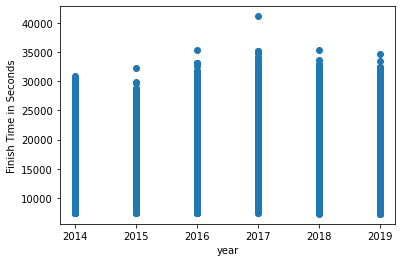

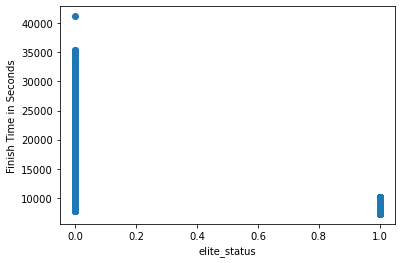

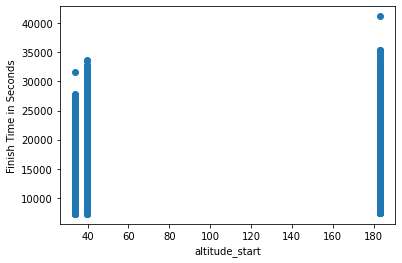

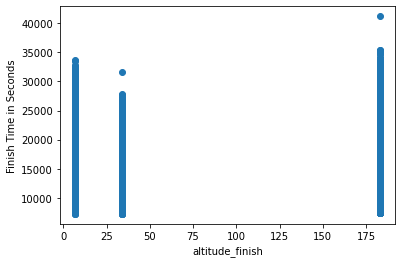

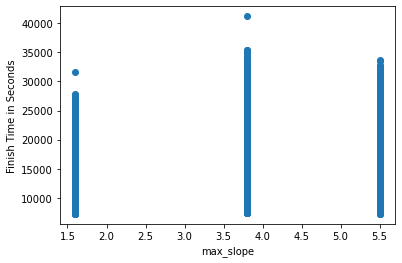

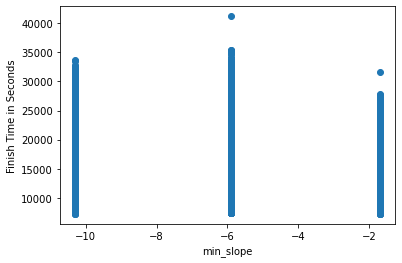

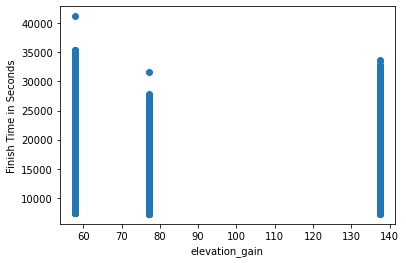

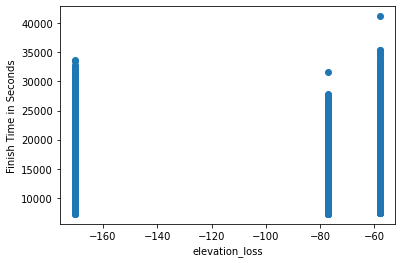

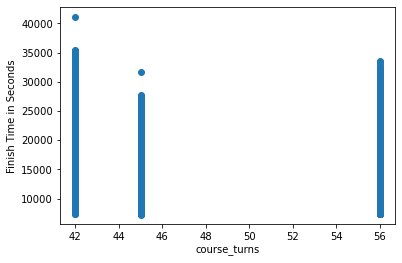

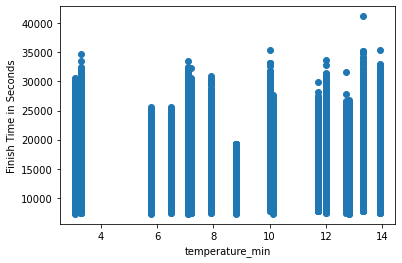

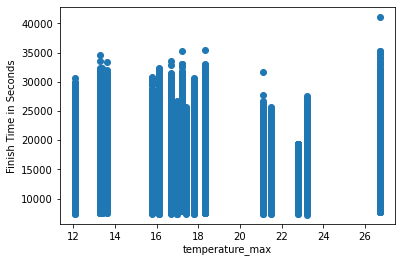

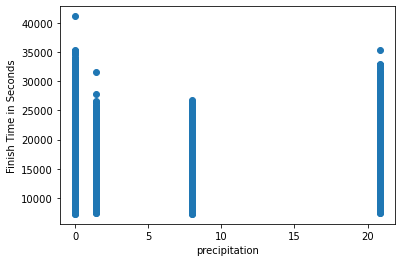

In [87]:
# Use a for loop to investigate relationships between dependent and independent variables

for col in marathon_independent_numeric_columns_df.columns: 
    plt.figure()
    plt.scatter(X[col], y)
    plt.ylabel('Finish Time in Seconds')
    plt.xlabel(col)
    plt.show();

The relationships between the dependent and numeric independent variables(before one hot encoding of the nationality and marathon name variables) were plotted above above. There appeared to be some linear relationships, so I decided to proceed with attempting a linear regression model. However, any output of this model, must be interpreted with caution as a correlation matrix above looking at these variables indicated some instances of multicollinearity between independent variables. 

#### Linear Regression

One Hot Encoding resulted in a large number of columns, use a KBest to get a better understanding of which features are contributing to the model. NOTE: Place_overall was removed as a feature. 

In [88]:
# Run a KBest/linear regression

train_scores = []
validation_scores = []

ks = list(range(1,61,1))
for k in ks:
    my_KBest = SelectKBest(f_regression, k=k).fit(X_train, y_train)
    
    X_train_selected = my_KBest.transform(X_train)
    X_validation_selected = my_KBest.transform(X_validation)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    print(f'k = {k}, {np.array(X_train.columns)[my_KBest.get_support()]}')
    #Store the score of my model
    train_scores.append(model.score(X_train_selected, y_train))
    validation_scores.append(model.score(X_validation_selected, y_validation))

/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 1, ['gender']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 2, ['gender' 'berlin']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 3, ['gender' 'USA' 'berlin']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 4, ['gender' 'max_slope' 'USA' 'berlin']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 5, ['gender' 'max_slope' 'min_slope' 'USA' 'berlin']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 6, ['gender' 'altitude_start' 'max_slope' 'min_slope' 'USA' 'berlin']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 7, ['gender' 'altitude_start' 'max_slope' 'min_slope' 'USA' 'berlin'
 'chicago']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 8, ['gender' 'altitude_start' 'altitude_finish' 'max_slope' 'min_slope' 'USA'
 'berlin' 'chicago']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 9, ['gender' 'altitude_start' 'altitude_finish' 'max_slope' 'min_slope' 'GER'
 'USA' 'berlin' 'chicago']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 10, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'GER' 'USA' 'berlin' 'chicago']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 11, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'ESP' 'GER' 'USA' 'berlin' 'chicago']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 12, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'ESP' 'FRA' 'GER' 'USA' 'berlin' 'chicago']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 13, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'ESP' 'FRA' 'GER' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 14, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'ESP' 'FRA' 'GBR' 'GER' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 15, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'ESP' 'FRA' 'GBR' 'GER' 'ITA' 'USA' 'berlin' 'chicago'
 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 16, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'temperature_min' 'ESP' 'FRA' 'GBR' 'GER' 'ITA' 'USA'
 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 17, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'temperature_min' 'DEN' 'ESP' 'FRA' 'GBR' 'GER' 'ITA' 'USA'
 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 18, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'temperature_min' 'DEN' 'ESP' 'FRA' 'GBR' 'GER' 'ITA' 'NOR'
 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 19, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'temperature_min' 'DEN' 'ESP' 'FRA' 'GBR' 'GER' 'INA' 'ITA'
 'NOR' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 20, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'temperature_min' 'DEN' 'ESP' 'FRA' 'GBR' 'GER' 'INA' 'ITA'
 'NOR' 'POL' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 21, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'temperature_min' 'DEN' 'ESP' 'FRA' 'GBR' 'GER' 'INA' 'ITA'
 'NED' 'NOR' 'POL' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 22, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'temperature_min' 'DEN' 'ESP' 'FRA' 'GBR' 'GER' 'INA' 'ITA'
 'NED' 'NOR' 'POL' 'SUI' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 23, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'temperature_min' 'DEN' 'ESP' 'FRA' 'GBR' 'GER' 'INA' 'IRL'
 'ITA' 'NED' 'NOR' 'POL' 'SUI' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 24, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'elevation_loss' 'temperature_min' 'DEN' 'ESP' 'FRA' 'GBR'
 'GER' 'INA' 'IRL' 'ITA' 'NED' 'NOR' 'POL' 'SUI' 'USA' 'berlin' 'chicago'
 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 25, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'elevation_loss' 'temperature_min' 'DEN' 'ESP' 'FRA' 'GBR'
 'GER' 'INA' 'IRL' 'ITA' 'NED' 'NOR' 'POL' 'RUS' 'SUI' 'USA' 'berlin'
 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 26, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'elevation_loss' 'temperature_min' 'DEN' 'ESP' 'FRA' 'GBR'
 'GER' 'INA' 'IRL' 'ITA' 'NED' 'NOR' 'PHL' 'POL' 'RUS' 'SUI' 'USA'
 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 27, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'elevation_loss' 'temperature_min' 'AUT' 'DEN' 'ESP' 'FRA'
 'GBR' 'GER' 'INA' 'IRL' 'ITA' 'NED' 'NOR' 'PHL' 'POL' 'RUS' 'SUI' 'USA'
 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 28, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'elevation_loss' 'temperature_min' 'AUT' 'BEL' 'DEN' 'ESP'
 'FRA' 'GBR' 'GER' 'INA' 'IRL' 'ITA' 'NED' 'NOR' 'PHL' 'POL' 'RUS' 'SUI'
 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 29, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'elevation_loss' 'temperature_min' 'AUT' 'BEL' 'DEN' 'ESP'
 'FRA' 'GBR' 'GER' 'INA' 'IRL' 'ITA' 'NED' 'NOR' 'PHL' 'POL' 'RUS' 'SUI'
 'SWE' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 30, ['elite_status' 'gender' 'altitude_start' 'altitude_finish' 'max_slope'
 'min_slope' 'elevation_loss' 'temperature_min' 'AUT' 'BEL' 'BRA' 'DEN'
 'ESP' 'FRA' 'GBR' 'GER' 'INA' 'IRL' 'ITA' 'NED' 'NOR' 'PHL' 'POL' 'RUS'
 'SUI' 'SWE' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 31, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_loss' 'temperature_min' 'AUT' 'BEL'
 'BRA' 'DEN' 'ESP' 'FRA' 'GBR' 'GER' 'INA' 'IRL' 'ITA' 'NED' 'NOR' 'PHL'
 'POL' 'RUS' 'SUI' 'SWE' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 32, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_loss' 'temperature_min' 'AUT' 'BEL'
 'BRA' 'DEN' 'ESP' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA' 'NED' 'NOR'
 'PHL' 'POL' 'RUS' 'SUI' 'SWE' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 33, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_loss' 'temperature_min' 'AUT' 'BEL'
 'BRA' 'CAN' 'DEN' 'ESP' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA' 'NED'
 'NOR' 'PHL' 'POL' 'RUS' 'SUI' 'SWE' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 34, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_loss' 'temperature_min' 'AUT' 'BEL'
 'BRA' 'CAN' 'DEN' 'ESP' 'ETH' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA'
 'NED' 'NOR' 'PHL' 'POL' 'RUS' 'SUI' 'SWE' 'USA' 'berlin' 'chicago'
 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 35, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_loss' 'temperature_min' 'AUT' 'BEL'
 'BRA' 'CAN' 'DEN' 'ESP' 'ETH' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA'
 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SUI' 'SWE' 'USA' 'berlin' 'chicago'
 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 36, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_loss' 'course_turns' 'temperature_min'
 'AUT' 'BEL' 'BRA' 'CAN' 'DEN' 'ESP' 'ETH' 'FRA' 'GBR' 'GER' 'INA' 'IND'
 'IRL' 'ITA' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SUI' 'SWE' 'USA'
 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 37, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_loss' 'course_turns' 'temperature_min'
 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'DEN' 'ESP' 'ETH' 'FRA' 'GBR' 'GER' 'INA'
 'IND' 'IRL' 'ITA' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SUI' 'SWE' 'USA'
 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 38, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_loss' 'course_turns' 'temperature_min'
 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'DEN' 'ESP' 'ETH' 'FRA' 'GBR' 'GER' 'INA'
 'IND' 'IRL' 'ITA' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SUI' 'SWE' 'TPE'
 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 39, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_loss' 'course_turns' 'temperature_min'
 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'DEN' 'ESP' 'ETH' 'FRA' 'GBR' 'GER' 'INA'
 'IND' 'IRL' 'ITA' 'KEN' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SUI' 'SWE'
 'TPE' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 40, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_loss' 'course_turns' 'temperature_min'
 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'DEN' 'ESP' 'ETH' 'FRA' 'GBR' 'GER'
 'INA' 'IND' 'IRL' 'ITA' 'KEN' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SUI'
 'SWE' 'TPE' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 41, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'DEN' 'ESP' 'ETH'
 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA' 'KEN' 'NED' 'NOR' 'PHL' 'POL'
 'POR' 'RUS' 'SUI' 'SWE' 'TPE' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 42, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'DEN' 'ESP' 'ETH'
 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA' 'KEN' 'NED' 'NOR' 'PHL'
 'POL' 'POR' 'RUS' 'SUI' 'SWE' 'TPE' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 43, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'DEN' 'ESP' 'ETH'
 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA' 'KEN' 'NED' 'NOR' 'PHL'
 'POL' 'POR' 'RUS' 'SUI' 'SWE' 'THA' 'TPE' 'USA' 'berlin' 'chicago'
 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 44, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'COL' 'DEN' 'ESP'
 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA' 'KEN' 'NED' 'NOR'
 'PHL' 'POL' 'POR' 'RUS' 'SUI' 'SWE' 'THA' 'TPE' 'USA' 'berlin' 'chicago'
 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 45, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'COL' 'CRC' 'DEN'
 'ESP' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA' 'KEN' 'NED'
 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SUI' 'SWE' 'THA' 'TPE' 'USA' 'berlin'
 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 46, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'COL' 'CRC' 'DEN'
 'ESP' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA' 'KEN' 'NED'
 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SLO' 'SUI' 'SWE' 'THA' 'TPE' 'USA'
 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 47, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'COL' 'CRC' 'DEN'
 'ESP' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA' 'KEN' 'NED'
 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SLO' 'SUI' 'SWE' 'THA' 'TPE' 'UKR' 'USA'
 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 48, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'COL' 'CRC'
 'DEN' 'ESP' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA' 'KEN'
 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SLO' 'SUI' 'SWE' 'THA' 'TPE' 'UKR'
 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 49, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'DEN' 'ESP' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL' 'ITA'
 'KEN' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SLO' 'SUI' 'SWE' 'THA' 'TPE'
 'UKR' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 50, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'CZE' 'DEN' 'ESP' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL'
 'ITA' 'KEN' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SLO' 'SUI' 'SWE' 'THA'
 'TPE' 'UKR' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 51, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'CZE' 'DEN' 'ESP' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL'
 'ITA' 'KEN' 'LTU' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SLO' 'SUI' 'SWE'
 'THA' 'TPE' 'UKR' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 52, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'CZE' 'DEN' 'ESP' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND' 'IRL'
 'ISR' 'ITA' 'KEN' 'LTU' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SLO' 'SUI'
 'SWE' 'THA' 'TPE' 'UKR' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 53, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'CZE' 'DEN' 'ESP' 'EST' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA' 'IND'
 'IRL' 'ISR' 'ITA' 'KEN' 'LTU' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS' 'SLO'
 'SUI' 'SWE' 'THA' 'TPE' 'UKR' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 54, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'CZE' 'DEN' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA'
 'IND' 'IRL' 'ISR' 'ITA' 'KEN' 'LTU' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS'
 'SLO' 'SUI' 'SWE' 'THA' 'TPE' 'UKR' 'USA' 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 55, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'CZE' 'DEN' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA'
 'IND' 'IRL' 'ISR' 'ITA' 'KEN' 'LTU' 'NED' 'NOR' 'PHL' 'POL' 'POR' 'RUS'
 'SLO' 'SUI' 'SVK' 'SWE' 'THA' 'TPE' 'UKR' 'USA' 'berlin' 'chicago'
 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 56, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'CZE' 'DEN' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA'
 'IND' 'IRL' 'ISL' 'ISR' 'ITA' 'KEN' 'LTU' 'NED' 'NOR' 'PHL' 'POL' 'POR'
 'RUS' 'SLO' 'SUI' 'SVK' 'SWE' 'THA' 'TPE' 'UKR' 'USA' 'berlin' 'chicago'
 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 57, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'CZE' 'DEN' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'INA'
 'IND' 'IRL' 'ISL' 'ISR' 'ITA' 'KEN' 'LTU' 'NED' 'NOR' 'PER' 'PHL' 'POL'
 'POR' 'RUS' 'SLO' 'SUI' 'SVK' 'SWE' 'THA' 'TPE' 'UKR' 'USA' 'berlin'
 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 58, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'CZE' 'DEN' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'HUN'
 'INA' 'IND' 'IRL' 'ISL' 'ISR' 'ITA' 'KEN' 'LTU' 'NED' 'NOR' 'PER' 'PHL'
 'POL' 'POR' 'RUS' 'SLO' 'SUI' 'SVK' 'SWE' 'THA' 'TPE' 'UKR' 'USA'
 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 59, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'CZE' 'DEN' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'HUN'
 'INA' 'IND' 'IRL' 'ISL' 'ISR' 'ITA' 'KEN' 'LTU' 'MAS' 'NED' 'NOR' 'PER'
 'PHL' 'POL' 'POR' 'RUS' 'SLO' 'SUI' 'SVK' 'SWE' 'THA' 'TPE' 'UKR' 'USA'
 'berlin' 'chicago' 'london']


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


k = 60, ['year' 'elite_status' 'gender' 'altitude_start' 'altitude_finish'
 'max_slope' 'min_slope' 'elevation_gain' 'elevation_loss' 'course_turns'
 'temperature_min' 'ARG' 'AUS' 'AUT' 'BEL' 'BRA' 'CAN' 'CHI' 'CHN' 'COL'
 'CRC' 'CZE' 'DEN' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FRA' 'GBR' 'GER' 'HUN'
 'INA' 'IND' 'IRL' 'ISL' 'ISR' 'ITA' 'KEN' 'LAT' 'LTU' 'MAS' 'NED' 'NOR'
 'PER' 'PHL' 'POL' 'POR' 'RUS' 'SLO' 'SUI' 'SVK' 'SWE' 'THA' 'TPE' 'UKR'
 'USA' 'berlin' 'chicago' 'london']


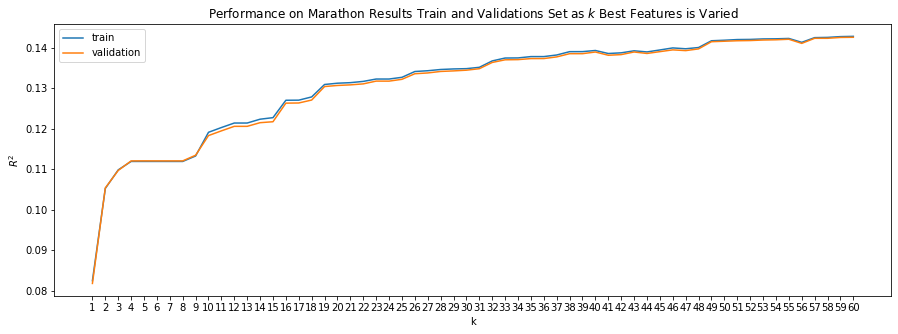

<Figure size 432x288 with 0 Axes>

In [104]:
plt.figure(figsize=(15,5))
plt.plot(ks, train_scores, label="train")
plt.plot(ks, validation_scores, label="validation")
plt.xticks(range(1,61,1))
plt.xlabel("k")
plt.xticks(size = 10)
plt.ylabel("$R^2$")
plt.yticks(size = 10)
plt.title("Performance on Marathon Results Train and Validations Set as $k$ Best Features is Varied")

plt.legend()
plt.show()
plt.savefig('Basic.png', dpi=300)

Clearly, place_overall was the primary feature contributing to the initial linear regression model explored above. Without it included, the model performance is extremely poor, even when including up to 60 features. 

In [90]:
# Check all correlations between dependent and independent variables
# Correlations between the dependent and independent variables are desirable
for col in X:
    correlation, p_value = stats.pearsonr(X[col], y)
    print(f"The correlation between finish time in seconds and {col} is {correlation} with p_value {round(p_value, 4)}.")

The correlation between finish time in seconds and year is 0.031471737164254006 with p_value 0.0.
The correlation between finish time in seconds and elite_status is -0.07397971991293802 with p_value 0.0.
The correlation between finish time in seconds and gender is 0.28726526464981883 with p_value 0.0.
The correlation between finish time in seconds and altitude_start is 0.12584312244734774 with p_value 0.0.
The correlation between finish time in seconds and altitude_finish is 0.09886179008445915 with p_value 0.0.
The correlation between finish time in seconds and max_slope is 0.159284366537327 with p_value 0.0.
The correlation between finish time in seconds and min_slope is -0.14868155823790974 with p_value 0.0.
The correlation between finish time in seconds and elevation_gain is 0.022945767479566864 with p_value 0.0.
The correlation between finish time in seconds and elevation_loss is -0.03703160730522584 with p_value 0.0.
The correlation between finish time in seconds and course_turns

The correlation between finish time in seconds and GHA is 0.0016927498336058323 with p_value 0.1535.
The correlation between finish time in seconds and GRD is 0.00020020044546807745 with p_value 0.866.
The correlation between finish time in seconds and GRE is -0.009904205123448117 with p_value 0.0.
The correlation between finish time in seconds and GRN is 0.003744028931487766 with p_value 0.0016.
The correlation between finish time in seconds and GUA is -0.004131358538556013 with p_value 0.0005.
The correlation between finish time in seconds and GUI is -0.0003314707998337915 with p_value 0.7799.
The correlation between finish time in seconds and GUM is 0.00016679294146076842 with p_value 0.8882.
The correlation between finish time in seconds and GUY is 0.0023286702496514255 with p_value 0.0496.
The correlation between finish time in seconds and HAI is 4.503507338533629e-05 with p_value 0.9697.
The correlation between finish time in seconds and HKG is -0.00046394407943117885 with p_valu

The correlation between finish time in seconds and SGP is -3.395046008423713e-05 with p_value 0.9772.
The correlation between finish time in seconds and SKN is -0.00017966817850094543 with p_value 0.8796.
The correlation between finish time in seconds and SLE is -0.0031777810593211575 with p_value 0.0074.
The correlation between finish time in seconds and SLO is -0.017300366700158668 with p_value 0.0.
The correlation between finish time in seconds and SMR is -0.004106966522705495 with p_value 0.0005.
The correlation between finish time in seconds and SOL is 0.001129520106057948 with p_value 0.3409.
The correlation between finish time in seconds and SOM is -0.0008330355044494776 with p_value 0.4825.
The correlation between finish time in seconds and SRB is -0.0053406365732520935 with p_value 0.0.
The correlation between finish time in seconds and SRI is -0.0006477870910651577 with p_value 0.585.
The correlation between finish time in seconds and STP is 0.0010681792895123362 with p_value

There appears to be significant correlation between the dependent variable and some of the independent variables. Not all of the nationality columns appear to be significantly correlated with the dependent varaible. I will proceed with trying to fit a Linear Regression (OLS) model. 

I initially chose to run an OLS model using stats models as I prefer the interpretability of the output.

In [91]:
# Instantiate the logistic regression model 
linreg_0 = sm.OLS(y, X_const_0)

# Fit the model (this returns a separate object with the parameters)
linreg_results_0 = linreg_0.fit()

# Display the results 
linreg_results_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     finish_time_seconds   R-squared:                       0.146
Model:                             OLS   Adj. R-squared:                  0.145
Method:                  Least Squares   F-statistic:                     599.7
Date:                 Sun, 05 Dec 2021   Prob (F-statistic):               0.00
Time:                         10:22:56   Log-Likelihood:            -6.7293e+06
No. Observations:               710813   AIC:                         1.346e+07
Df Residuals:                   710610   BIC:                         1.346e+07
Df Model:                          202                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.324e+09   1.28e+10      0.570      0.568   -1.78e+10    3.25e+10
year               54.7923      2.759     19.857      0.000      49.384      60.200
elite_status    -7038.3674    118.993    -59.149      0.000   -7271.591   -6805.144
gender           1749.4208      7.910    221.170      0.000    1733.918    1764.924
altitude_start   2.436e+11    1.1e+11      2.212      0.027    2.77e+10    4.59e+11
altitude_finish -3.091e+11   1.59e+11     -1.944      0.052   -6.21e+11    2.52e+09
max_slope        6.867e+10   7.97e+10      0.862      0.389   -8.75e+10    2.25e+11
min_slope       -7.201e+11   7.42e+11     -0.971      0.332   -2.17e+12    7.34e+11
elevation_gain  -5.444e+11   8.54e+11     -0.637      0.524   -2.22e+12    1.13e+12
elevation_loss  -8.088e+10   3.46e+11     -0.233      0.815    -7.6e+11    5.98e+11
course_turns     8.155e+11   9.09e+11      0.897      0.370   -9.66e+11     2.6e+12
temperature_min    71.9687      2.005     35.888      0.000      68.038      75.899
temperature_max    16.0839      1.645      9.779      0.000      12.860      19.307
precipitation     -28.0456      1.029    -27.259      0.000     -30.062     -26.029
AFG             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
ALB             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
ALG             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
AND             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
ANG             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
ANT             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
ARG             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
ARM             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
ARU             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
ASA             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
AUS             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
AUT             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
AZE             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
BAH             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
BAN             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
BAR             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
BDI             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
BEL             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
BEN             -2.542e+08   3.03e+08     -0.840      0.401   -8.47e+08    3.39e+08
BER             -2.542e+08   3.03e+08     -0.840

The OLS output indicated that the R Squared value was 0.146 after removing place_overall. With place_overall included the R Squared value was 0.86. There is a lot of room for improvement of this model. 

In [92]:
# Retrieve the residuals
linreg_model_resids = linreg_results_0.resid

# Retrieve the fitted values
linreg_model_fittedvals = linreg_results_0.fittedvalues 

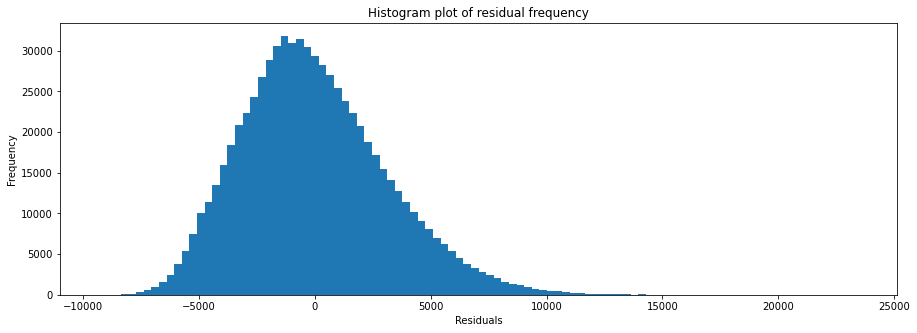

In [93]:
# Plot a histogram of the residuals
plt.figure(figsize = (15,5))
plt.hist(linreg_model_resids, bins = 100)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram plot of residual frequency')
plt.show()

The above histogram plot of the residuals is not a perfect normal distribution as it is slightly skewed to the right. 

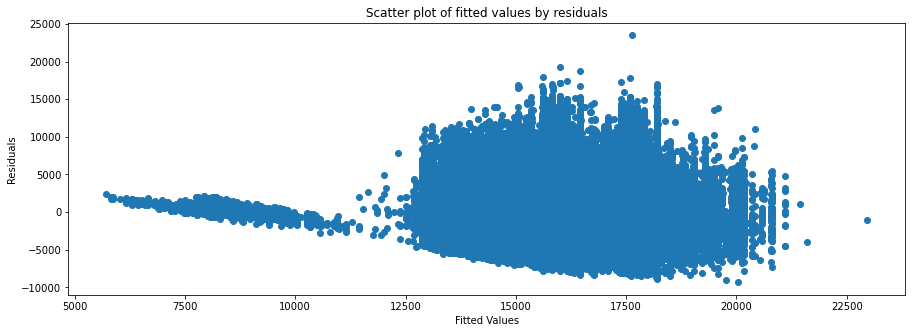

In [95]:
# Scatter plot of fitted values vs. residuals
plt.figure(figsize = (15,5))
plt.scatter(linreg_model_fittedvals, linreg_model_resids)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Scatter plot of fitted values by residuals')
plt.show()

The plot of the fitted values vs. the residuals does not appear totally random. This lack of randomness indicates that the last assumption of the linear model (homoscedasticity) is being violated. Given that the mean absolute error was very high, the assumption of homoscedasticity was violated and, that some of the independent variables are highly correlated, this model is not a good fit for the data. 

#### Fit the same linear model using scikit learn

In [96]:
# Create linear regression object
marathon_regr_0 = linear_model.LinearRegression()

# Train the model using the training sets
marathon_regr_0.fit(X_remainder, y_remainder)

# Make predictions using the testing set
marathon_y_pred = marathon_regr_0.predict(X_test)

# Use this to print the coefficients if desired
# print("Coefficients: \n", marathon_regr_0.coef_)

# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, marathon_y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, marathon_y_pred))
# Score the model 
marathon_regr_0.score(X_test, y_test)


Mean absolute error: 74406.61
Coefficient of determination: -16093085.18


-16093085.178633917

This output further confirms that the model became significantly worse after removing place_overall. For instance, the mean absolute error went from 753 seconds to 74406.61 seconds. The R-Squared score from SKlearn is (-16093085) is very differnt from that of the OLS above (0.146), but it shows that this model is not a good for the data. 

#### Try Adding L2 Regularization (Ridge Regression)
L2 Regularization encourages coefficients to be smaller. The following will only be done on the train/test split to get a sense of the effect of L2 Regularization. Hyperparameter optimization will be completed later, if this demonstrates improvement.

In [97]:
# Run a linear model with Ridge Regression 
marathon_ridge_reg_0 = Ridge()
marathon_ridge_reg_0.fit(X_remainder, y_remainder)

print(f"Linear Regression (None) for train data: {marathon_regr_0.score(X_test, y_test)}")
print(f"R^2 of the Ridge Regression (L2) for train data: {marathon_ridge_reg_0.score(X_test, y_test)}")


Linear Regression (None) for train data: -16093085.178633917
R^2 of the Ridge Regression (L2) for train data: 0.14580047743963498


It appears that the default Ridge Regression (loss function = the linear least squares function) alpha of 1.0 improved the performance of the model over the basic sklearn linear model as the R Squared value is now positive.

In [98]:
# Run a linear model with Lasso Regression

# The max_iter was increased to 2000, after 1000 was found to not be enough
# Selection was changed to random from cyclic, this updates random coefficients every cycle, 
# rather than looping over sequentially - this was done in attempt to reach convergence more quickly
marathon_lasso_reg_0 = Lasso(max_iter = 2000, selection = 'random')
marathon_lasso_reg_0.fit(X_remainder, y_remainder)

print(f"Linear Regression (None) for test data: {marathon_regr_0.score(X_test, y_test)}")
print(f"R^2 of the Ridge Regression (L2) for test data: {marathon_ridge_reg_0.score(X_test, y_test)}")
print(f"R^2 of the Lasso Regression (L1) for test data: {marathon_lasso_reg_0.score(X_test, y_test)}")


/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2086880503766.171, tolerance: 651477818.4025818
  model = cd_fast.enet_coordinate_descent(


Linear Regression (None) for test data: -16093085.178633917
R^2 of the Ridge Regression (L2) for test data: 0.14580047743963498
R^2 of the Lasso Regression (L1) for test data: 0.1437716780387951


Lasso Regression was not able to provide any improvement beyond Ridge Regression. Next, Principal Component and Partial Least Squares Regression will be attempted. 

#### Principal Component and Partial Least Squares Regression
NOTE: This code was sourced from: https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html

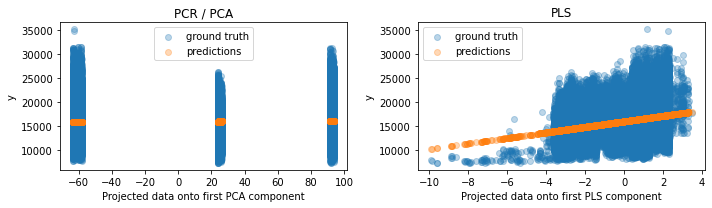

In [99]:
# Run Principal Component Regression and Partial Least Squares Regression

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_remainder, y_remainder)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_remainder, y_remainder)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [100]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared 0.000
PLS r-squared 0.093


Principal Component Regression process: 
- 1) Principal Component Analysis (PCA) is applied to the training data (exploring dimensionality reduction). This transformation is unsupervised (no information about the targets is used). 
- 2) A regressor (e.g. a linear regressor) is trained on PCA transformed samples. 
As no information about target is used in PCA, PCR may not perform well in datasets where the target is strongly correlated with directions that have low variance. Indeed, the dimensionality reduction of PCA projects the data into a lower dimensional space where the variance of the projected data is greedily maximized along each axis. Despite them having the most predictive power on the target, the directions with a lower variance will be dropped, and the final regressor will not be able to leverage them.

Partial Least Squares Regression (PLS) process: 
- 1) Applies a dimensionality reduction to the samples
- 2) Applies a linear regressor to the transformed data.
BUT, the key difference between PLS and PCR, is that the PLS transformation is supervised and can perform better in datasets where the the target is strongly correlated with directions that have low variance. 

PLS greatly outperformed PCR (based on the R Squared output), but the R Squared value for PLS is still below those obtained using OLS, Ridge and Lasso Regression above. It is possible that these models will show improved performance with an optimized n_components parameter.

### Decision Tree Regression

In [101]:
# Instantiate and fit a Decision Tree Regression model
marathon_DT_model_0 = DecisionTreeRegressor()
marathon_DT_model_0.fit(X_remainder, y_remainder)

print(f"DT R^2 score on training (X_remainder) set: {marathon_DT_model_0.score(X_remainder, y_remainder):0.3f}")
print(f"DT R^2 score on test set: {marathon_DT_model_0.score(X_test, y_test):0.3f}")

DT R^2 score on training (X_remainder) set: 0.162
DT R^2 score on test set: 0.154


The baseline decision tree model above used the default max_depth which expands the nodes until all leaves are pure or until all leaves contain less than min_samples_split samples. The default min_samples_split = 2. The scores (R Squared) for this model were improved relative to the linear regression models above, but are still poor. 

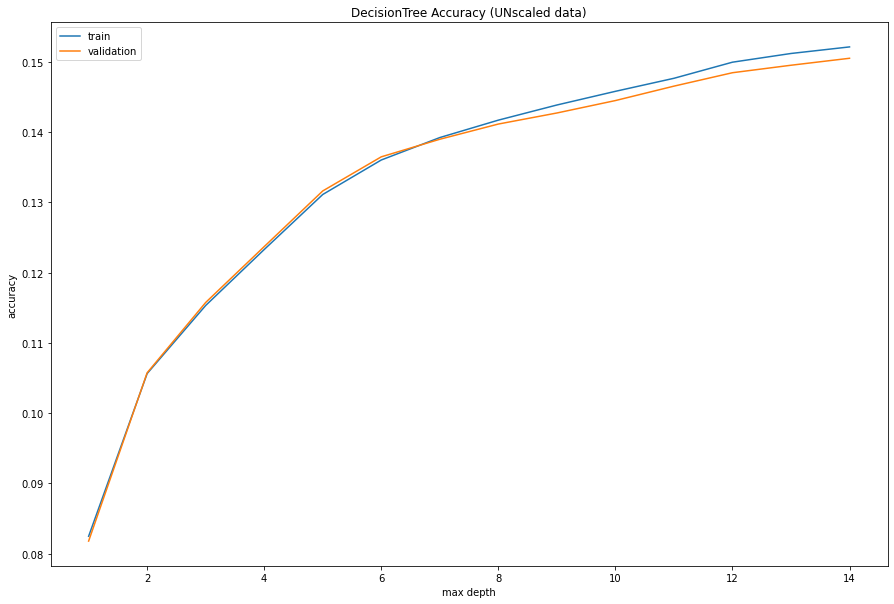

In [102]:
# Decision Tree - unscaled data

train_accs = []
test_accs = []
depth_values = list(range(1,15))

# Loop over different max_depths
for d in depth_values:
    
    # Instantiate & fit
    marathon_DT_model_1 = DecisionTreeRegressor(max_depth = d)
    marathon_DT_model_1.fit(X_train, y_train)
    
    # Evaluate on train & test data
    train_accs.append(marathon_DT_model_1.score(X_train, y_train))
    test_accs.append(marathon_DT_model_1.score(X_validation, y_validation))

plt.figure(figsize=(15, 10))
plt.plot(depth_values, train_accs, label = 'train')
plt.plot(depth_values, test_accs, label = 'validation')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('DecisionTree Accuracy (UNscaled data)')
plt.show()

Increasing the max depth parameter did help to increse the accuracy (R-Squared value) of the Decision Tree model.  However, as the the max depth increases, the distance between the train and validation set scores also starts to increase indicating that the model is likely starting to overfit on the train set. Overall, the scores for the Decision Tree model are still poor. 

#### Try an XG Boost Model

In [103]:
# Instantiate and fit a default XGBoost regression model

marathon_XGB_model_0 = XGBRegressor()
marathon_XGB_model_0.fit(X_train, y_train)
print(f"XG Boost score: {marathon_XGB_model_0.score(X_validation, y_validation)}")

XG Boost score: 0.1557354340386694


The default XGBoost model had a slightly improved score over the default Decision Tree model above, but with an R-Squared value of 0.156 it is still quite poor. 

The accuracy scores of the various models above are poor with this data. Rather than investing time in attempting to optimize the hyperparameters of the various models above, I will look at a reduced dataset (data from the London Marathon only) in attempt to build a more meaningful predictive model. If time permits, I will do the same for the Chicago and Berlin marathons as well. I chose to start with London as I had age_class and half_split as additional features. 

#### Conclusions

The combined dataset created in this notebook was useful in analyzing trends between and within the marathons, but was not suitable for attempting to build a predictive model. As a next step, a subset of data (results from the London Marathon) will be used to try and build a predictive model. 